# **EDA + VISUALIZACIÓN + PREPROCESAMIENTO**
---

**Objetivo**

En este RolePlay tendremos el papel de Juan, un data scientist recién fichado para la empresa TrenMax en la posición Data Scientist.

TrenMax es una empresa recién llegada a España que ha obtenido la licencia de operar trenes en el país, ellos necesitan hacer un análisis de mercado de la competencia para preparar precios competitivos de viajes, para ello contrataron a una consultora que les ha dado la información en un dataset que ha podido recopilar de la competencia.

En este dataset se encuentra los viajes históricos recopilados de la empresa de la competencia, así como el precio ofertado, con ello la idea del CEO María es poder hacer un modelo predictivo que me permita predecir el precio del billete de la competencia para poder ajustar de esta manera el nuestro cuando salga a la venta.

Para ello María le pide a Juan los siguientes pasos:

1. Importación del fichero desde Drive
2. Hacer el EDA: exploratory data analysis
3. Realizar el preprocesamiento de datos


**Instalación de librerías**

In [2]:
#pip install folium

**Importación de librerías**

In [3]:
import time

# Sistema operativo
import os

# Pandas y Numpy
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Mapa iteractivo (por defecto OpenStreetMap)
import folium

# Versiones de las librerías instaladas
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Folium version {folium.__version__}")

# transformers
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Config
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

Working with these versions of libraries

Numpy version 1.21.5
Pandas version 1.4.4
Folium version 0.14.0


**Creación de carpetas**

In [ ]:
dir = ['csv', 'report', 'pickle', 'final', 'predict']
for i in dir:
    os.mkdir(i)
del dir

**Ruta del dataset**

In [4]:
# Si se usa Collab
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
CWD = os.getcwd() # Ruta actual
DATA_PATH = os.path.join(CWD, "data") # Ruta de la carpeta Data

print(CWD)
print(DATA_PATH)

d:\Data_Science\EDA_CLEANING_PREPROCCESING\EDA_VISUALIZACION_PREPROCESAMIENTO_RENFE
d:\Data_Science\EDA_CLEANING_PREPROCCESING\EDA_VISUALIZACION_PREPROCESAMIENTO_RENFE\data


**Clases y funciones**

In [6]:
# Elimina duplicados
def drop_duplicates (df):
    '''
    Elimina filas duplicadas del dataset
    '''
    print(f"{df.shape}")
    df_duplicated = df[df.duplicated(keep = False)]
    print(f"Se han eliminado {len(df[df.duplicated()])} registros repetidos")
    df.drop_duplicates(inplace = True)
    print(f"{df.shape}")

    return df_duplicated

**DataFrameReporter**
Nos va a permitir hacer un primer contacto con el dataset.\
Se trata de una clase auxiliar que hará una parte del **EDA**.

In [7]:
class DataFrameReporter(object):
    '''
    Helper class that reports nulls and datatypes of columns
    '''
    def __init__(self, df): # Variables que le tengo que suministrar a la clase
        '''
        Constructor for the class.
        Needs dataframe
        '''
        self.df = df
               
    def analyze_X(self, X):
        '''
        Analyses the DataFrame you pass and returns a report of nulls, distribution and other goodies.
        '''        
               
        dtypes = X.dtypes.to_frame().rename(columns = {0:"Dtypes"}) # Tipos de variables

        nulls_in_X = X.isnull().sum().to_frame().rename(columns = {0:"Absolute_nulls"}) # Número de nulos en las variables
        nulls_in_X["Relative_nulls"] = nulls_in_X["Absolute_nulls"]/X.shape[0]
        nulls_in_X["Relative_nulls"] = nulls_in_X["Relative_nulls"].apply(
            lambda number: round(number, 3) * 100 # Relative_nulls = (Absolute_nulls/Shape)*100 ... con 3 cifras significativas
        )
        
        nulls_in_X = pd.concat([nulls_in_X, dtypes], axis = 1)
        nulls_in_X["Shape"] = X.shape[0] # Número de registros
        nulls_in_X = nulls_in_X[["Dtypes", "Shape", "Absolute_nulls", "Relative_nulls"]] # Ordeno las columnas

         
        describe_values_num = X.describe().T # Describe de las variables numéricas
        report_df = pd.concat([nulls_in_X, describe_values_num], axis = 1)
               
        describe_values_cat = X.describe(exclude = "number").T # Describe de las variables categóricas
        report_df = pd.concat([report_df, describe_values_cat], axis = 1)

        report_df.fillna("", inplace = True) # Imputo los nulos con un vacío
        report_df.sort_values("Dtypes", ascending = True, inplace = True) # Ordeno las variables por tipos
        
        return report_df
        
    def get_reports(self):
        '''
        Calls analyze_X method and returns report DataFrame for train and test.
        '''
        report_df = self.analyze_X(X = self.df)
                
        return report_df

In [8]:
# Nulos en variables
def nulos_variable (dataframe):
    ''' 
    Muestra los nulos que hay
    '''
    nulos_numericas = dataframe.select_dtypes(include = np.number).isnull().sum()[dataframe.select_dtypes(include = np.number).isnull().sum() > 0]
    nulos_categoricas =dataframe.select_dtypes(exclude = np.number).isnull().sum()[dataframe.select_dtypes(exclude = np.number).isnull().sum() > 0]

    print ('Las variables numéricas que tienen nulos son:\n', nulos_numericas, '\n\nHay un total de', len(nulos_numericas), 'variables numéricas con nulos')
    print ('\n\nLas variables categóricas que tienen nulos son:\n', nulos_categoricas, '\n\nHay un total de', len(nulos_categoricas), 'variables categóricas con nulos')
    print ('\n\nVARIABLES TOTALES CON NULOS:', len(nulos_numericas)+len(nulos_categoricas))

In [9]:
# Separación de variables
target = ['PRECIO'] # indico quién es la variable a predecir

def obtener_lista_variables(dataset):
  ''' 
  Obtengo listas de variables
  '''

  lista_numerica=[]
  lista_boolean=[] # numerica y con 2 valores
  lista_categorica=[] # object sin datatime

  for i in dataset: # si no especifico, aplica a las columnas (es como poner for i in dataset.columns:)
    if (dataset[i].dtype.kind == 'i'or dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'b') and len(dataset[i].unique())!=2\
     and i not in target:
      lista_numerica.append(i)
    elif (dataset[i].dtype.kind == 'i'or dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'b') and len(dataset[i].unique()) ==2\
     and i not in target:
      lista_boolean.append(i)
    elif (dataset[i].dtype.kind == 'O') and i not in target: # pongo elif y no else para que no me entre el datetime como categorica
      lista_categorica.append(i)


  return lista_numerica, lista_boolean, lista_categorica

In [10]:
# Visualización del target
def plot_target(dataframe, target):
    ''' 
    Visualización del target
    '''
    
    plt.figure(figsize=(15,4))
    plt.title(f'Analisis del {target}')  

    ax1 = plt.subplot (1,2,1)
    ax1 = sns.boxplot(x = dataframe[target])
    ax2 = plt.subplot (1,2,2)
    ax2 = plt.hist(x = dataframe[target]) 

In [11]:
# Análisis de las variables numéricas VS target
def analisis_numericas (dataframe, column, target):
    '''
    Pivot-table que me da las medidas de las variables numericas y su correlación con el target
    '''
    
    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len, min, np.mean, max]).sort_values(by=(column),ascending=True)

In [12]:
# Visualización de las variables numéricas VS target
def plot_numericas(dataframe,column,target):
    '''
    Visualización de las variables numéricas y su correlación con el target
    '''  
      
    plt.figure(figsize=[10,4])
    plt.title(f'Analisis de {column} VS {target}')
    if column=='HIJOS':
        sns.boxplot(x = column, y = target, data = dataframe, palette="coolwarm")
    
    else:
        sns.scatterplot(x = column, y = target, data = dataframe )
  
    return plt.show()

In [13]:
# Análisis de las variables categóricas VS target
def analisis_categoricas (dataframe,column,target):
    '''
    Pivot-table que me da las medidas de las variables categóricas y su correlación con el target
    '''

    print(f"\nANÁLISIS DE {column} CON RESPECTO AL {target}\n")
    
    return dataframe.pivot_table(index=column, values=target, aggfunc=[len,sum,np.mean]).sort_values(by=('len', target),ascending=False)

In [14]:
# Visualización de las variables categóricas VS target
def plot_categoricas(dataframe,column,target):
    '''
    Visualización de las variables categóricas y su correlación con el target
    '''    
    
    plt.figure(figsize=[12,4])
    plt.title(f'Analisis de {column} VS {target}')
    
    ax1 = plt.subplot (1,2,1)
    ax1 = sns.boxplot(x=column, y=target, data= dataframe, palette="coolwarm")
    ax2 = plt.subplot (1,2,2)
    ax2 = sns.violinplot(x=column, y=target, data= dataframe, palette="coolwarm")  

    return plt.show()

In [15]:
# column --> columna sobre la que actuamos
# num_values --> número de eqiquetas que queremos limitar

def setOthers(dataframe, column, num_values): 
    ''' 
    Reduce el número de etiquetas de la variable
    '''
    
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others', inplace = True) 

In [16]:
def corr_alta (dataframe):
    ''' 
    Variables con alta correlación
    '''
    corr = dataframe.corr()
    corr2 = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    corr2 = corr2.stack(level = -1 , dropna = True)
    corr_variables = corr2.sort_values()[(corr2.sort_values()>=0.85) | (corr2.sort_values()<=-0.85)] # Indico el grado de correlación

    return corr_variables

## **1.- Data Loading**

In [17]:
# Cargar un CSV en df
renfe = pd.read_csv (os.path.join(DATA_PATH, "renfe.csv"), sep=";")
renfe.head()

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO
0,2019-05-25 01:43:03,2019-06-28 20:36:00,2019-06-28 23:14:00,SEVILLA,MADRID,ALVIA,Flexible,Turista,67.20
1,2019-06-22 13:05:11,2019-07-14 10:00:00,2019-07-14 13:10:00,BARCELONA,MADRID,AVE,Flexible,Turista,107.70
2,2019-04-17 06:24:03,2019-05-23 13:40:00,2019-05-23 16:10:00,SEVILLA,MADRID,AVE,Promo,Turista,47.30
3,2019-05-10 21:21:59,2019-05-29 14:50:00,2019-05-29 22:30:00,VALENCIA,MADRID,REGIONAL,Adulto ida,Turista,28.35
4,2019-05-09 19:43:37,2019-06-26 13:25:00,2019-06-26 16:24:00,MADRID,BARCELONA,AVE-TGV,Promo,Turista,66.75


## **2.- EDA: exploratory data analysis**

**Anáilis descriptivo rápido de las variables**

In [18]:
# Generamos el report para las variables ... Llama a la función get_reports() de la clase DataFrameReporter()
report_renfe = DataFrameReporter(df = renfe).get_reports()
report_renfe

,Dtypes,Shape,Absolute_nulls,Relative_nulls,count,mean,std,min,25%,50%,75%,max,count,unique,top,freq
PRECIO,float64,383568,28530,7.40,"355,038.00",61.44,25.70,0.00,41.20,58.15,76.30,342.80,,,,
FECHA_CONSULTA,object,383568,0,0.00,,,,,,,,,383568,226818,2019-06-02 11:01:46,13
FECHA_INICIO,object,383568,0,0.00,,,,,,,,,383568,18161,2019-06-02 17:30:00,185
FECHA_FIN,object,383568,0,0.00,,,,,,,,,383568,23200,2019-05-30 14:20:00,111
CIUDAD_ORIGEN,object,383568,0,0.00,,,,,,,,,383568,5,MADRID,191663
CIUDAD_DESTINO,object,383568,0,0.00,,,,,,,,,383568,5,MADRID,191905
TIPO_TREN,object,383568,0,0.00,,,,,,,,,383568,16,AVE,262635
TIPO_TARIFA,object,383568,1343,0.40,,,,,,,,,382225,10,Promo,266497
CLASE,object,383568,1343,0.40,,,,,,,,,382225,9,Turista,290756


In [19]:
# Lo exporto a excel para poder trabajar con el
#os.mkdir('report')
report_renfe.to_excel('report/renfe_describe.xlsx')

### 2.1. ANÁLISIS UNIVARIANTE

**PREGUNTA 1**:\
***Lo primero hay que ver si tenemos nulos, ¿Me puedes decir qué variables tenemos nulos?***

In [20]:
renfe.isnull().sum()

FECHA_CONSULTA        0
FECHA_INICIO          0
FECHA_FIN             0
CIUDAD_ORIGEN         0
CIUDAD_DESTINO        0
TIPO_TREN             0
TIPO_TARIFA        1343
CLASE              1343
PRECIO            28530
dtype: int64

Hay nulos en  "TIPO_TARIFA", "CLASE" y "PRECIO"

**pregunta 2:**\
***Vamos a ver la estructura del dataset, ¿Te has dado cuenta que las columnas fechas podemos convertirlas a date? ¿Recuerdas cómo se hace?***

In [21]:
renfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383568 entries, 0 to 383567
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   FECHA_CONSULTA  383568 non-null  object 
 1   FECHA_INICIO    383568 non-null  object 
 2   FECHA_FIN       383568 non-null  object 
 3   CIUDAD_ORIGEN   383568 non-null  object 
 4   CIUDAD_DESTINO  383568 non-null  object 
 5   TIPO_TREN       383568 non-null  object 
 6   TIPO_TARIFA     382225 non-null  object 
 7   CLASE           382225 non-null  object 
 8   PRECIO          355038 non-null  float64
dtypes: float64(1), object(8)
memory usage: 26.3+ MB


In [22]:
list_date = ['FECHA_CONSULTA', 'FECHA_INICIO', 'FECHA_FIN']

In [23]:
for date in list_date:
    renfe[date] = pd.to_datetime(renfe[date])

In [24]:
renfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383568 entries, 0 to 383567
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   FECHA_CONSULTA  383568 non-null  datetime64[ns]
 1   FECHA_INICIO    383568 non-null  datetime64[ns]
 2   FECHA_FIN       383568 non-null  datetime64[ns]
 3   CIUDAD_ORIGEN   383568 non-null  object        
 4   CIUDAD_DESTINO  383568 non-null  object        
 5   TIPO_TREN       383568 non-null  object        
 6   TIPO_TARIFA     382225 non-null  object        
 7   CLASE           382225 non-null  object        
 8   PRECIO          355038 non-null  float64       
dtypes: datetime64[ns](3), float64(1), object(5)
memory usage: 26.3+ MB


**PREGUNTA 3:**\
***¿Hay duplicados? ¿En caso haya cuántos son? (borrarlo en caso existan)***

In [25]:
drop_duplicates (df = renfe)

(383568, 9)
Se han eliminado 33 registros repetidos
(383535, 9)


,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO
8530,2019-06-10 01:10:54,2019-07-07 21:03:00,2019-07-07 23:28:00,VALENCIA,MADRID,INTERCITY,Promo,Turista,43.75
9179,2019-08-17 03:22:19,2019-09-01 21:03:00,2019-09-01 23:28:00,VALENCIA,MADRID,INTERCITY,Flexible,Turista,NaN
14256,2019-05-03 05:33:32,2019-05-24 15:10:00,2019-05-24 17:20:00,MADRID,VALENCIA,INTERCITY,Promo,Turista,43.75
24392,2019-05-15 21:26:30,2019-06-23 21:05:00,2019-06-23 23:32:00,VALENCIA,MADRID,INTERCITY,NaN,NaN,NaN
29786,2019-05-13 05:35:59,2019-05-26 17:30:00,2019-05-26 19:43:00,VALENCIA,MADRID,INTERCITY,Flexible,Turista,55.40
33847,2019-05-17 15:22:08,2019-07-11 21:03:00,2019-07-11 23:28:00,VALENCIA,MADRID,INTERCITY,NaN,NaN,NaN
35335,2019-04-30 09:09:51,2019-05-19 17:30:00,2019-05-19 19:43:00,VALENCIA,MADRID,INTERCITY,Flexible,Turista,55.40
44739,2019-04-19 09:10:48,2019-04-21 17:30:00,2019-04-21 19:43:00,VALENCIA,MADRID,INTERCITY,Flexible,Turista,NaN
56591,2019-04-29 23:15:13,2019-05-14 06:20:00,2019-05-14 14:25:00,MADRID,BARCELONA,LD-AVE,Promo,Turista,NaN
62201,2019-05-15 23:37:01,2019-06-21 21:05:00,2019-06-21 23:32:00,VALENCIA,MADRID,INTERCITY,NaN,NaN,NaN


**PREGUNTA 4:**\
***Crear dos variables, que serán super interesantes y probablemente importantes para el modelo:\
a) Tiempo_Viaje: variable que me indica en minutos la duración del viaje.\
b) Dif_Ini_Bus: variable que me indica en minutos la diferencia entre la fecha de inicio de viaje y la fecha de búsqueda.***

In [26]:
renfe['TIEMPO_VIAJE'] = (renfe['FECHA_FIN'] - renfe['FECHA_INICIO'])/np.timedelta64(1,'m')
renfe['DIF_INIT_BUS'] = (renfe['FECHA_INICIO'] - renfe['FECHA_CONSULTA'])/np.timedelta64(1,'m')
renfe.head()

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO,TIEMPO_VIAJE,DIF_INIT_BUS
0,2019-05-25 01:43:03,2019-06-28 20:36:00,2019-06-28 23:14:00,SEVILLA,MADRID,ALVIA,Flexible,Turista,67.20,158.00,"50,092.95"
1,2019-06-22 13:05:11,2019-07-14 10:00:00,2019-07-14 13:10:00,BARCELONA,MADRID,AVE,Flexible,Turista,107.70,190.00,"31,494.82"
2,2019-04-17 06:24:03,2019-05-23 13:40:00,2019-05-23 16:10:00,SEVILLA,MADRID,AVE,Promo,Turista,47.30,150.00,"52,275.95"
3,2019-05-10 21:21:59,2019-05-29 14:50:00,2019-05-29 22:30:00,VALENCIA,MADRID,REGIONAL,Adulto ida,Turista,28.35,460.00,"26,968.02"
4,2019-05-09 19:43:37,2019-06-26 13:25:00,2019-06-26 16:24:00,MADRID,BARCELONA,AVE-TGV,Promo,Turista,66.75,179.00,"68,741.38"


**PREGUNTA 5:**\
***Separa las fechas por hora, día de la semana, día y mes***

In [27]:
# Sólo dispongo de fechas del 2019. No es necesario agregar una columna para el año
renfe['FECHA_CONSULTA'].dt.year.value_counts()

2019    383535
Name: FECHA_CONSULTA, dtype: int64

In [28]:
for col in list_date:
    renfe[col+'_HORA'] = renfe[col].dt.hour
    renfe[col+'_NOMBREDIA'] = renfe[col].dt.day_name()
    #renfe[col+'_HORA'] = renfe[col].dt.weekday_name
    renfe[col+'_DIA'] = renfe[col].dt.day
    renfe[col+'_MES'] = renfe[col].dt.month
    #renfe[col+'_AÑO'] = renfe[col].dt.year
renfe.head().T


,0,1,2,3,4
FECHA_CONSULTA,2019-05-25 01:43:03,2019-06-22 13:05:11,2019-04-17 06:24:03,2019-05-10 21:21:59,2019-05-09 19:43:37
FECHA_INICIO,2019-06-28 20:36:00,2019-07-14 10:00:00,2019-05-23 13:40:00,2019-05-29 14:50:00,2019-06-26 13:25:00
FECHA_FIN,2019-06-28 23:14:00,2019-07-14 13:10:00,2019-05-23 16:10:00,2019-05-29 22:30:00,2019-06-26 16:24:00
CIUDAD_ORIGEN,SEVILLA,BARCELONA,SEVILLA,VALENCIA,MADRID
CIUDAD_DESTINO,MADRID,MADRID,MADRID,MADRID,BARCELONA
TIPO_TREN,ALVIA,AVE,AVE,REGIONAL,AVE-TGV
TIPO_TARIFA,Flexible,Flexible,Promo,Adulto ida,Promo
CLASE,Turista,Turista,Turista,Turista,Turista
PRECIO,67.20,107.70,47.30,28.35,66.75
TIEMPO_VIAJE,158.00,190.00,150.00,460.00,179.00


**PREGUNTA 6:**\
***En el precio existen nulos, ¿Qué porcentaje representa del total del dataset?***


In [29]:
round(((renfe['PRECIO'].isnull().sum())/renfe.shape[0])*100,2)

7.43

**PREGUNTA 7:**\
***Vamos a analizar los nulos de cada columna***

In [30]:
nulos_variable (dataframe = renfe)

Las variables numéricas que tienen nulos son:
 PRECIO    28515
dtype: int64 

Hay un total de 1 variables numéricas con nulos


Las variables categóricas que tienen nulos son:
 TIPO_TARIFA    1338
CLASE          1338
dtype: int64 

Hay un total de 2 variables categóricas con nulos


VARIABLES TOTALES CON NULOS: 3


In [31]:
renfe['CLASE'].value_counts(dropna=False)

Turista                     290733
Preferente                   37761
Turista Plus                 27069
Turista con enlace           23264
TuristaSólo plaza H           2724
NaN                           1338
PreferenteSólo plaza H         343
Cama Turista                   285
Cama G. Clase                   16
Turista PlusSólo plaza H         2
Name: CLASE, dtype: int64

In [32]:
len(renfe[renfe['CLASE'].isnull()])

1338

In [33]:
len(renfe[renfe['CLASE'].isnull() & renfe['CLASE'].isnull() & renfe['PRECIO'].isnull()])

1338

Los nulos de CLASE son los mismos que los de TIPO_TARIFA y los de PRECIO.\
Eliminando los de una columna, eliminamos los de las otras dos.

In [34]:
renfe.dropna(subset=['CLASE'], inplace=True)

In [35]:
renfe['PRECIO'].value_counts(dropna=False)

NaN       27177
85.10     18629
28.35     18409
76.30     17566
107.70    13762
          ...  
342.80        1
30.91         1
29.75         1
57.05         1
49.14         1
Name: PRECIO, Length: 293, dtype: int64

In [36]:
renfe[renfe['PRECIO'].isnull()]

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_CONSULTA_HORA,FECHA_CONSULTA_NOMBREDIA,FECHA_CONSULTA_DIA,FECHA_CONSULTA_MES,FECHA_INICIO_HORA,FECHA_INICIO_NOMBREDIA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_NOMBREDIA,FECHA_FIN_DIA,FECHA_FIN_MES
12,2019-04-23 15:21:49,2019-05-10 06:11:00,2019-05-10 11:57:00,PONFERRADA,MADRID,LD,Promo,Turista,NaN,346.00,"23,929.18",15,Tuesday,23,4,6,Friday,10,5,11,Friday,10,5
28,2019-04-13 10:10:53,2019-04-22 12:00:00,2019-04-22 14:32:00,MADRID,SEVILLA,AVE,Promo,Preferente,NaN,152.00,"13,069.12",10,Saturday,13,4,12,Monday,22,4,14,Monday,22,4
33,2019-06-20 09:32:55,2019-06-30 19:19:00,2019-06-30 21:59:00,SEVILLA,MADRID,INTERCITY,Flexible,TuristaSólo plaza H,NaN,160.00,"14,986.08",9,Thursday,20,6,19,Sunday,30,6,21,Sunday,30,6
43,2019-04-12 15:11:10,2019-05-27 14:10:00,2019-05-27 16:03:00,MADRID,VALENCIA,AVE,Promo,Turista,NaN,113.00,"64,738.83",15,Friday,12,4,14,Monday,27,5,16,Monday,27,5
50,2019-06-20 09:32:11,2019-07-07 09:50:00,2019-07-07 12:36:00,SEVILLA,MADRID,ALVIA,Promo,Turista,NaN,166.00,"24,497.82",9,Thursday,20,6,9,Sunday,7,7,12,Sunday,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383461,2019-04-17 05:18:54,2019-05-26 18:35:00,2019-05-26 21:08:00,MADRID,SEVILLA,ALVIA,Promo,Turista,NaN,153.00,"56,956.10",5,Wednesday,17,4,18,Sunday,26,5,21,Sunday,26,5
383483,2019-04-13 08:29:55,2019-05-22 16:05:00,2019-05-22 22:47:00,MADRID,VALENCIA,REGIONAL,Adulto ida,Turista,NaN,402.00,"56,615.08",8,Saturday,13,4,16,Wednesday,22,5,22,Wednesday,22,5
383512,2019-05-22 09:07:00,2019-05-30 13:30:00,2019-05-30 16:05:00,MADRID,SEVILLA,ALVIA,Promo,Turista,NaN,155.00,"11,783.00",9,Wednesday,22,5,13,Thursday,30,5,16,Thursday,30,5
383522,2019-05-31 05:30:14,2019-06-16 14:58:00,2019-06-16 17:50:00,SEVILLA,MADRID,ALVIA,Promo,Preferente,NaN,172.00,"23,607.77",5,Friday,31,5,14,Sunday,16,6,17,Sunday,16,6


Las filas de los nulos nos ofrecen ofrecen información útil.\
Pero no podemos reemplazar los nulos por un precio medio o una mediana, debido a los diferentes tipos de tarifa y tipos de tren, con lo que estaríamos distorsionando el dataset.\
Elimino los nulos del PRECIO

In [37]:
renfe.dropna(subset=['PRECIO'], inplace=True)

In [38]:
renfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355020 entries, 0 to 383567
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   FECHA_CONSULTA            355020 non-null  datetime64[ns]
 1   FECHA_INICIO              355020 non-null  datetime64[ns]
 2   FECHA_FIN                 355020 non-null  datetime64[ns]
 3   CIUDAD_ORIGEN             355020 non-null  object        
 4   CIUDAD_DESTINO            355020 non-null  object        
 5   TIPO_TREN                 355020 non-null  object        
 6   TIPO_TARIFA               355020 non-null  object        
 7   CLASE                     355020 non-null  object        
 8   PRECIO                    355020 non-null  float64       
 9   TIEMPO_VIAJE              355020 non-null  float64       
 10  DIF_INIT_BUS              355020 non-null  float64       
 11  FECHA_CONSULTA_HORA       355020 non-null  int64         
 12  FE

**PREGUNTA 8:**\
***Analiza el resto de las variables con un "value_counts" o con un "hist" cada una de ellas según sean numéricas o string (con un "for" iría mejor), ¿Ves alguna variable que hay que limpiarla?¿Qué haya outlier?¿Qué haya datos que no tienen sentido a nivel de negocio? realizar un mini resumen variable a variable si ves algo raro con ellas.\
Cuando hayas terminado el proceso de limpieza crea una copia del dataset con el nombre de "renfe_clean".***

In [39]:
renfe[renfe['PRECIO']==0]

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_CONSULTA_HORA,FECHA_CONSULTA_NOMBREDIA,FECHA_CONSULTA_DIA,FECHA_CONSULTA_MES,FECHA_INICIO_HORA,FECHA_INICIO_NOMBREDIA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_NOMBREDIA,FECHA_FIN_DIA,FECHA_FIN_MES
121961,2019-06-17 09:01:21,2019-08-03 20:00:00,2019-08-03 23:10:00,BARCELONA,MADRID,AVE,4x100,Turista,0.00,190.00,"68,338.65",9,Monday,17,6,20,Saturday,3,8,23,Saturday,3,8
136925,2019-06-13 01:13:29,2019-06-16 12:50:00,2019-06-16 15:45:00,BARCELONA,MADRID,AVE-TGV,Flexible,Preferente,0.00,175.00,"5,016.52",1,Thursday,13,6,12,Sunday,16,6,15,Sunday,16,6


In [40]:
list_precio_0 = renfe[renfe['PRECIO']==0].index.to_list()

Elimino estos dos registros por tener precio igual a 0

In [41]:
renfe.drop(list_precio_0, axis = 0, inplace = True)

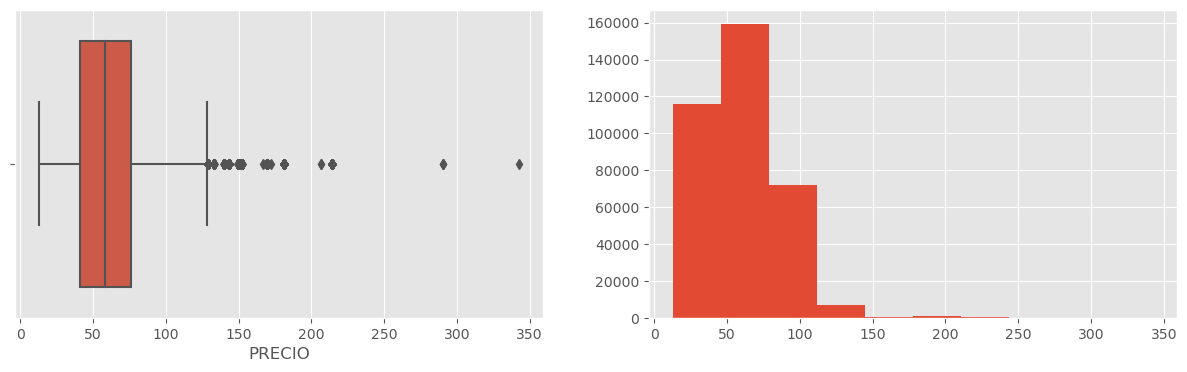

In [42]:
plot_target(dataframe = renfe, target = 'PRECIO')

El comportamiento del precio es normal, ya que la mayor parte de la masa se encuentra en los precios bajos.\
El target sigue una distribución de Skewed (está sesgada hacia la izquierda) --> **se recomienda normalizarlo creando la variable LOG_PRECIO.** 

In [43]:
renfe[renfe['PRECIO']>215]

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_CONSULTA_HORA,FECHA_CONSULTA_NOMBREDIA,FECHA_CONSULTA_DIA,FECHA_CONSULTA_MES,FECHA_INICIO_HORA,FECHA_INICIO_NOMBREDIA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_NOMBREDIA,FECHA_FIN_DIA,FECHA_FIN_MES
16565,2019-06-18 13:50:02,2019-06-20 07:00:00,2019-06-20 09:30:00,MADRID,BARCELONA,AVE,Mesa,Preferente,342.80,150.00,"2,469.97",13,Tuesday,18,6,7,Thursday,20,6,9,Thursday,20,6
202466,2019-06-15 01:13:12,2019-06-18 09:30:00,2019-06-18 12:34:00,MADRID,BARCELONA,AVE,Mesa,Preferente,290.40,184.00,"4,816.80",1,Saturday,15,6,9,Tuesday,18,6,12,Tuesday,18,6
253028,2019-06-17 07:51:12,2019-06-18 09:30:00,2019-06-18 12:34:00,MADRID,BARCELONA,AVE,Mesa,Preferente,290.40,184.00,"1,538.80",7,Monday,17,6,9,Tuesday,18,6,12,Tuesday,18,6
376642,2019-06-15 03:27:23,2019-06-18 09:30:00,2019-06-18 12:34:00,MADRID,BARCELONA,AVE,Mesa,Preferente,290.40,184.00,"4,682.62",3,Saturday,15,6,9,Tuesday,18,6,12,Tuesday,18,6


In [44]:
list_precio_outliers = renfe[renfe['PRECIO']>215].index.to_list()
list_precio_outliers

[16565, 202466, 253028, 376642]

Elimino estos 4 outliers

In [45]:
renfe.drop(list_precio_outliers, axis = 0, inplace = True)

In [46]:
renfe['LOG_PRECIO']=np.log10(renfe['PRECIO'])

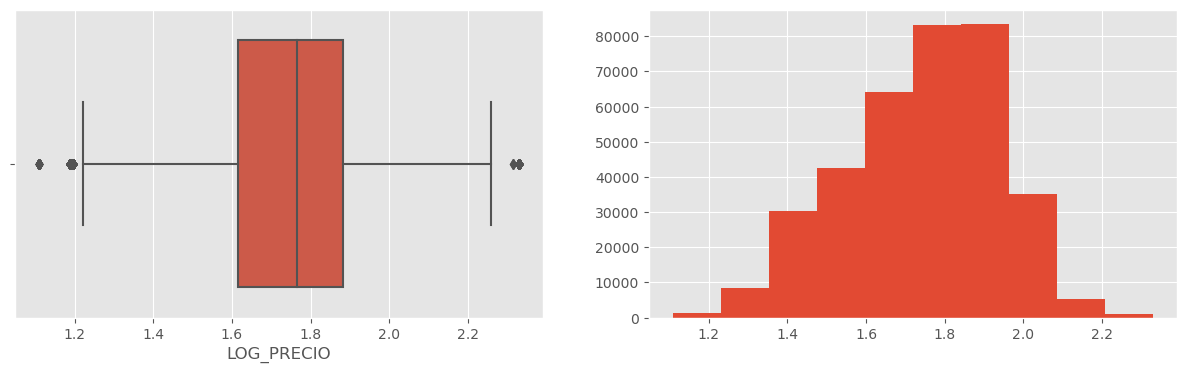

In [47]:
plot_target(dataframe = renfe, target = 'LOG_PRECIO')

In [48]:
target = ['PRECIO', 'LOG_PRECIO']
list_num, list_bool, list_cat = obtener_lista_variables(dataset = renfe)

In [49]:
for num in list_num:
    print(renfe[num].value_counts(),'\n')

150.00    46126
190.00    34480
152.00    31492
100.00    26867
165.00    23150
113.00    12015
158.00    11588
160.00     9305
170.00     8403
141.00     7741
104.00     5720
145.00     5566
107.00     5258
180.00     5020
163.00     4399
172.00     4307
102.00     3625
377.00     3566
175.00     3529
256.00     3183
156.00     3171
109.00     2686
98.00      2638
544.00     2635
135.00     2582
184.00     2576
252.00     2551
155.00     2481
179.00     2473
153.00     2415
407.00     2333
403.00     2315
462.00     2190
243.00     2141
415.00     2104
250.00     2097
272.00     2043
112.00     2026
162.00     1985
562.00     1968
458.00     1884
402.00     1883
244.00     1879
182.00     1871
303.00     1808
167.00     1762
300.00     1744
460.00     1743
233.00     1717
159.00     1714
171.00     1609
411.00     1581
461.00     1526
176.00     1512
337.00     1469
168.00     1391
139.00     1364
101.00     1349
147.00     1331
108.00     1285
389.00     1251
130.00     1223
421.00  

In [50]:
# Hay 512 registros con 'Dif_Ini_Bus' negativos --> Hay que eliminarlos
renfe[renfe['DIF_INIT_BUS']<0].sort_values('DIF_INIT_BUS', ascending=False)

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_CONSULTA_HORA,FECHA_CONSULTA_NOMBREDIA,FECHA_CONSULTA_DIA,FECHA_CONSULTA_MES,FECHA_INICIO_HORA,FECHA_INICIO_NOMBREDIA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_NOMBREDIA,FECHA_FIN_DIA,FECHA_FIN_MES,LOG_PRECIO
27858,2019-08-16 00:04:42,2019-08-15 21:25:00,2019-08-15 23:55:00,MADRID,BARCELONA,AVE,Promo,Turista,75.40,150.00,-159.70,0,Friday,16,8,21,Thursday,15,8,23,Thursday,15,8,1.88
38714,2019-04-24 00:20:04,2019-04-23 21:25:00,2019-04-23 23:55:00,MADRID,BARCELONA,AVE,Promo,Turista,66.75,150.00,-175.07,0,Wednesday,24,4,21,Tuesday,23,4,23,Tuesday,23,4,1.82
344650,2019-04-24 00:25:59,2019-04-23 21:15:00,2019-04-24 00:02:00,BARCELONA,MADRID,AVE,Promo,Turista,75.40,167.00,-190.98,0,Wednesday,24,4,21,Tuesday,23,4,0,Wednesday,24,4,1.88
310274,2019-05-19 00:37:40,2019-05-18 21:25:00,2019-05-18 23:55:00,BARCELONA,MADRID,AVE,Promo,Preferente,143.40,150.00,-192.67,0,Sunday,19,5,21,Saturday,18,5,23,Saturday,18,5,2.16
85166,2019-04-26 01:40:37,2019-04-25 22:14:00,2019-04-26 04:31:00,MADRID,PONFERRADA,TRENHOTEL,Individual-Flexible,Cama G. Clase,150.60,377.00,-206.62,1,Friday,26,4,22,Thursday,25,4,4,Friday,26,4,2.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30328,2019-07-29 17:59:10,2019-07-01 21:03:00,2019-07-01 23:28:00,VALENCIA,MADRID,INTERCITY,Flexible,TuristaSólo plaza H,55.40,145.00,"-40,136.17",17,Monday,29,7,21,Monday,1,7,23,Monday,1,7,1.74
240347,2019-07-29 18:07:13,2019-07-01 20:36:00,2019-07-01 23:14:00,SEVILLA,MADRID,ALVIA,Flexible,Turista,67.20,158.00,"-40,171.22",18,Monday,29,7,20,Monday,1,7,23,Monday,1,7,1.83
81689,2019-07-29 18:22:39,2019-07-01 20:40:00,2019-07-01 22:24:00,MADRID,VALENCIA,AVE,Promo,Turista,57.75,104.00,"-40,182.65",18,Monday,29,7,20,Monday,1,7,22,Monday,1,7,1.76
342192,2019-07-29 18:22:43,2019-06-30 20:40:00,2019-06-30 22:24:00,MADRID,VALENCIA,AVE,Promo,Turista,57.75,104.00,"-41,622.72",18,Monday,29,7,20,Sunday,30,6,22,Sunday,30,6,1.76


In [51]:
renfe.drop((renfe[renfe['DIF_INIT_BUS']<0]).index, inplace=True)

Los viajes corresponden a los meses del 5 al 10 y los meses en los que se han hecho consultas son del 5 al 8 (con muy pocas consultas en el mes 7). Elimino esta variable.

In [52]:
del renfe['FECHA_CONSULTA_MES']

Vemos los posibles outliers en TIEMPO_VIAJE

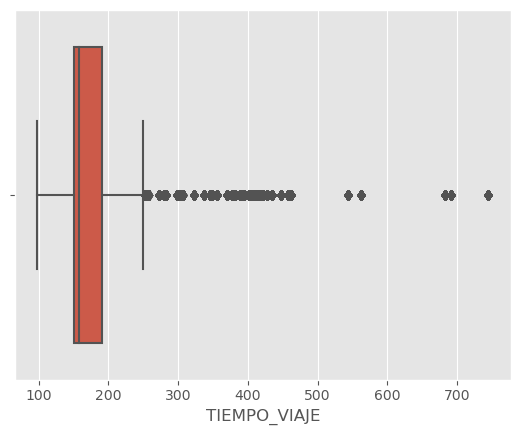

In [53]:
sns.boxplot(x = renfe['TIEMPO_VIAJE']);

In [54]:
renfe[renfe['TIEMPO_VIAJE']>600].sort_values(by=['TIEMPO_VIAJE'], ascending = False)

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,PRECIO,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_CONSULTA_HORA,FECHA_CONSULTA_NOMBREDIA,FECHA_CONSULTA_DIA,FECHA_INICIO_HORA,FECHA_INICIO_NOMBREDIA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_NOMBREDIA,FECHA_FIN_DIA,FECHA_FIN_MES,LOG_PRECIO
382970,2019-04-24 21:21:29,2019-05-25 08:45:00,2019-05-25 21:10:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,745.00,"43,883.52",21,Wednesday,24,8,Saturday,25,5,21,Saturday,25,5,1.72
271712,2019-05-11 05:32:17,2019-05-25 08:45:00,2019-05-25 21:10:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,745.00,"20,352.72",5,Saturday,11,8,Saturday,25,5,21,Saturday,25,5,1.72
275191,2019-04-27 07:38:27,2019-06-01 08:45:00,2019-06-01 21:10:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,745.00,"50,466.55",7,Saturday,27,8,Saturday,1,6,21,Saturday,1,6,1.72
274550,2019-04-30 11:23:17,2019-06-02 08:45:00,2019-06-02 21:10:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,745.00,"47,361.72",11,Tuesday,30,8,Sunday,2,6,21,Sunday,2,6,1.72
274215,2019-05-26 23:28:35,2019-06-01 08:45:00,2019-06-01 21:10:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,745.00,"7,756.42",23,Sunday,26,8,Saturday,1,6,21,Saturday,1,6,1.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107824,2019-06-17 11:05:52,2019-07-06 08:45:00,2019-07-06 20:08:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,683.00,"27,219.13",11,Monday,17,8,Saturday,6,7,20,Saturday,6,7,1.72
107670,2019-08-03 17:47:25,2019-08-24 08:45:00,2019-08-24 20:08:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,683.00,"29,697.58",17,Saturday,3,8,Saturday,24,8,20,Saturday,24,8,1.72
107540,2019-06-19 05:22:24,2019-07-13 08:45:00,2019-07-13 20:08:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,683.00,"34,762.60",5,Wednesday,19,8,Saturday,13,7,20,Saturday,13,7,1.72
283963,2019-08-04 07:22:56,2019-08-15 08:45:00,2019-08-15 20:08:00,SEVILLA,MADRID,MD,Flexible,Turista con enlace,52.50,683.00,"15,922.07",7,Sunday,4,8,Thursday,15,8,20,Thursday,15,8,1.72


In [55]:
renfe[(renfe['CIUDAD_ORIGEN']=='SEVILLA') & (renfe['CIUDAD_DESTINO']=='MADRID') & (renfe['TIPO_TREN']=='MD')]['TIEMPO_VIAJE'].value_counts()

691.00    192
745.00    184
683.00    170
Name: TIEMPO_VIAJE, dtype: int64

Consultando fuentes de internet, un recorrido en tren de media distancia de Sevilla a Madrid tiene una duración de 240 minutos.\
Estos 547 registros son claramente outliers. Los elimino.

In [56]:
list_tiempo_viaje_outliers = renfe[(renfe['CIUDAD_ORIGEN']=='SEVILLA') & (renfe['CIUDAD_DESTINO']=='MADRID') & (renfe['TIPO_TREN']=='MD')].index.to_list()

In [57]:
renfe.drop(list_tiempo_viaje_outliers, axis = 0, inplace = True)

In [58]:
for cat in list_cat:
    print(renfe[cat].value_counts(), '\n')

MADRID        176520
BARCELONA      59720
SEVILLA        53031
VALENCIA       51959
PONFERRADA     12725
Name: CIUDAD_ORIGEN, dtype: int64 

MADRID        177435
BARCELONA      60583
VALENCIA       54587
SEVILLA        52972
PONFERRADA      8378
Name: CIUDAD_DESTINO, dtype: int64 

AVE          251592
ALVIA         21097
REGIONAL      18380
INTERCITY     18207
AV City       10226
MD-LD          7511
AVE-TGV        4907
R. EXPRES      4597
TRENHOTEL      4201
LD             4062
AVE-LD         3158
LD-MD          2597
AVE-MD         2577
MD-AVE          843
Name: TIPO_TREN, dtype: int64 

Promo                      250892
Flexible                    71367
Adulto ida                  22977
Promo +                      8537
COD.PROMOCIONAL               163
Individual-Flexible            12
Mesa                            3
Doble Familiar-Flexible         3
Grupos Ida                      1
Name: TIPO_TARIFA, dtype: int64 

Turista                     270609
Preferente                   3

En TIPO_TREN unificamos MD-LD y LD-MD. Y unificamos AVE-MD y MD-AVE

In [59]:
renfe['TIPO_TREN'] = np.where(renfe['TIPO_TREN']=='LD-MD', 'MD-LD', renfe['TIPO_TREN'])

In [60]:
renfe['TIPO_TREN'] = np.where(renfe['TIPO_TREN']=='MD-AVE', 'AVE-MD', renfe['TIPO_TREN'])

En TIPO_TARIFA y CLASE, se reduce a 5 etiquetas

In [61]:
for var in ['TIPO_TARIFA', 'CLASE']:
    setOthers(dataframe = renfe, column = var, num_values = 4)

In [62]:
for var in ['TIPO_TARIFA', 'CLASE']:
    print(renfe[var].value_counts(),'\n')

Promo         250892
Flexible       71367
Adulto ida     22977
Promo +         8537
Others           182
Name: TIPO_TARIFA, dtype: int64 

Turista               270609
Preferente             34052
Turista Plus           25884
Turista con enlace     20748
Others                  2662
Name: CLASE, dtype: int64 



In [63]:
renfe.reset_index (inplace = True)
del renfe['index']

In [64]:
renfe = renfe[[
    'FECHA_CONSULTA', 'FECHA_INICIO', 'FECHA_FIN', 'CIUDAD_ORIGEN',
    'CIUDAD_DESTINO', 'TIPO_TREN', 'TIPO_TARIFA', 'CLASE', 
    'TIEMPO_VIAJE', 'DIF_INIT_BUS', 'FECHA_CONSULTA_HORA',
    'FECHA_CONSULTA_NOMBREDIA', 'FECHA_CONSULTA_DIA', 'FECHA_INICIO_HORA',
    'FECHA_INICIO_NOMBREDIA', 'FECHA_INICIO_DIA', 'FECHA_INICIO_MES',
    'FECHA_FIN_HORA', 'FECHA_FIN_NOMBREDIA', 'FECHA_FIN_DIA',
    'FECHA_FIN_MES', 'PRECIO', 'LOG_PRECIO'
]]

**PREGUNTA 9: Contestar a las siguientes cuestiones**

**A. ¿Cuál es la fecha mínima y máxima de consulta de las simulaciones?**

In [65]:
print(renfe['FECHA_CONSULTA'].min())
print(renfe['FECHA_CONSULTA'].max())

2019-04-11 21:49:46
2019-08-22 19:06:26


**B. ¿Cuál es el precio mímino, máximo y medio del billete?**

In [66]:
renfe['PRECIO'].describe()

count   353,955.00
mean         61.42
std          25.67
min          12.85
25%          41.20
50%          58.15
75%          76.30
max         214.20
Name: PRECIO, dtype: float64

**C. ¿Cuántas rutas se simularon en el mes de agosto de 2019?**

In [67]:
gb_inicio_mes = renfe.groupby('FECHA_INICIO_MES')
gb_inicio_mes.get_group(8).shape[0]

32638

**D. ¿Cuántas rutas se simularon que la duración del viaje sea superior a 4 horas?**

In [68]:
len(renfe[renfe['TIEMPO_VIAJE']>(4*60)])

54967

**E. ¿Puedes decir cuál es la ciudad que menos simulaciones se han hecho como origen y cuántas simulaciones fueron?**

In [69]:
renfe.groupby('CIUDAD_ORIGEN')['FECHA_INICIO'].agg(len)

CIUDAD_ORIGEN
BARCELONA      59720
MADRID        176520
PONFERRADA     12725
SEVILLA        53031
VALENCIA       51959
Name: FECHA_INICIO, dtype: int64

**F. Calcular la clase más barata y la clase más cara**

In [70]:
renfe.groupby('CLASE')['PRECIO'].agg(['min', 'max'])

,min,max
CLASE,,
Turista,12.85,172.40
Preferente,27.70,214.20
Turista Plus,15.45,206.80
Turista con enlace,17.10,76.40
Others,27.90,150.60


**G. Calcular la tarifa más cara en el mes de viaje en septiembre de 2019**

In [71]:
renfe.groupby('FECHA_INICIO_MES')['PRECIO'].agg(['max'])

,max
FECHA_INICIO_MES,
4,214.20
5,214.20
6,214.20
7,181.50
8,181.50
9,129.30
10,107.70


**H. ¿En promedio cuál es el tipo de tren más barato y de cuánto?**

In [72]:
renfe.groupby('TIPO_TREN')['PRECIO'].agg([np.mean]).sort_values('mean', ascending=True)

,mean
TIPO_TREN,
REGIONAL,28.35
MD-LD,38.53
INTERCITY,39.00
R. EXPRES,43.25
AVE-LD,44.63
LD,46.64
AV City,47.27
TRENHOTEL,47.89
AVE-MD,53.76


**I. ¿Cuántas rutas se simularon entre origen MADRID y destino BARCELONA?**

In [73]:
gb_origen_madrid = renfe.groupby('CIUDAD_ORIGEN').get_group('MADRID')
len(gb_origen_madrid[gb_origen_madrid['CIUDAD_DESTINO']=='BARCELONA'])

60583

**J. En promedio ¿Cuál es el mes más barato para viajar desde BARCELONA a MADRID en AVE y de cuánto?**

In [74]:
df_precio_mean = renfe.groupby(['FECHA_INICIO_MES','CIUDAD_ORIGEN', 'CIUDAD_DESTINO'])['PRECIO'].agg(['mean']).rename(columns={'mean':'PRECIO_MEDIO'}).reset_index()
df_precio_mean[(df_precio_mean['CIUDAD_ORIGEN']=='BARCELONA') & (df_precio_mean['CIUDAD_DESTINO']=='MADRID')].sort_values('PRECIO_MEDIO')

,FECHA_INICIO_MES,CIUDAD_ORIGEN,CIUDAD_DESTINO,PRECIO_MEDIO
48,10,BARCELONA,MADRID,55.87
32,8,BARCELONA,MADRID,75.72
40,9,BARCELONA,MADRID,78.26
24,7,BARCELONA,MADRID,85.19
8,5,BARCELONA,MADRID,86.57
16,6,BARCELONA,MADRID,88.44
0,4,BARCELONA,MADRID,92.02


**K. Calcular el precio medio del billete teniendo como ciudad origen MADRID, destino VALENCIA para el mes de viaje AGOSTO**

In [75]:
renfe[(renfe['FECHA_INICIO_MES']==8) & (renfe['CIUDAD_ORIGEN']=='MADRID') & (renfe['CIUDAD_DESTINO']=='VALENCIA')]['PRECIO'].mean()

37.8849268018021

**PREGUNTA 10:**\
**Pinta un mapa de las ciudades en el que se muestre el tiempo medio de viaje por cada ciudad origen. ¿Qué ciudad tiene el mayor tiempo medio?**

In [76]:
#importamos fichero de latitudes y longitudes
coordenadas = pd.read_csv('data/LAT_LONG_CIUDADES.CSV', sep=';')
coordenadas

,PROVINCIA,LATITUD,LONGITUD
0,MADRID,40.42,-3.70
1,BARCELONA,41.38,2.18
2,SEVILLA,37.39,-6.00
3,VALENCIA,39.47,-0.38
4,PONFERRADA,42.55,-6.59


In [77]:
# Agrego las coordenadas al dataset
renfe_coordenadas = renfe.merge(coordenadas, how='inner', left_on='CIUDAD_ORIGEN', right_on='PROVINCIA').rename(columns={'PROVINCIA':'PROVINCIA_ORIGEN','LATITUD':'LATITUD_ORIGEN', 'LONGITUD':'LONGITUD_ORIGEN'})
renfe_coordenadas

,FECHA_CONSULTA,FECHA_INICIO,FECHA_FIN,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_CONSULTA_HORA,FECHA_CONSULTA_NOMBREDIA,FECHA_CONSULTA_DIA,FECHA_INICIO_HORA,FECHA_INICIO_NOMBREDIA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_NOMBREDIA,FECHA_FIN_DIA,FECHA_FIN_MES,PRECIO,LOG_PRECIO,PROVINCIA_ORIGEN,LATITUD_ORIGEN,LONGITUD_ORIGEN
0,2019-05-25 01:43:03,2019-06-28 20:36:00,2019-06-28 23:14:00,SEVILLA,MADRID,ALVIA,Flexible,Turista,158.00,"50,092.95",1,Saturday,25,20,Friday,28,6,23,Friday,28,6,67.20,1.83,SEVILLA,37.39,-6.00
1,2019-04-17 06:24:03,2019-05-23 13:40:00,2019-05-23 16:10:00,SEVILLA,MADRID,AVE,Promo,Turista,150.00,"52,275.95",6,Wednesday,17,13,Thursday,23,5,16,Thursday,23,5,47.30,1.67,SEVILLA,37.39,-6.00
2,2019-06-08 03:19:48,2019-07-21 08:45:00,2019-07-21 11:15:00,SEVILLA,MADRID,AVE,Promo,Turista,150.00,"62,245.20",3,Saturday,8,8,Sunday,21,7,11,Sunday,21,7,60.30,1.78,SEVILLA,37.39,-6.00
3,2019-08-17 13:40:02,2019-10-15 16:45:00,2019-10-15 19:17:00,SEVILLA,MADRID,AVE,Promo,Turista,152.00,"85,144.97",13,Saturday,17,16,Tuesday,15,10,19,Tuesday,15,10,60.30,1.78,SEVILLA,37.39,-6.00
4,2019-08-17 17:36:52,2019-09-13 06:45:00,2019-09-13 09:15:00,SEVILLA,MADRID,AVE,Promo,Turista,150.00,"38,228.13",17,Saturday,17,6,Friday,13,9,9,Friday,13,9,53.40,1.73,SEVILLA,37.39,-6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353950,2019-05-14 21:37:11,2019-05-20 11:44:00,2019-05-20 16:00:00,PONFERRADA,MADRID,MD-LD,Flexible,Turista con enlace,256.00,"8,046.82",21,Tuesday,14,11,Monday,20,5,16,Monday,20,5,54.10,1.73,PONFERRADA,42.55,-6.59
353951,2019-06-18 07:49:13,2019-07-10 06:11:00,2019-07-10 10:15:00,PONFERRADA,MADRID,ALVIA,Promo,Turista,244.00,"31,581.78",7,Tuesday,18,6,Wednesday,10,7,10,Wednesday,10,7,33.50,1.53,PONFERRADA,42.55,-6.59
353952,2019-04-28 15:32:49,2019-05-22 11:44:00,2019-05-22 16:00:00,PONFERRADA,MADRID,MD-LD,Flexible,Turista con enlace,256.00,"34,331.18",15,Sunday,28,11,Wednesday,22,5,16,Wednesday,22,5,54.10,1.73,PONFERRADA,42.55,-6.59
353953,2019-04-15 05:15:54,2019-05-04 11:44:00,2019-05-04 16:00:00,PONFERRADA,MADRID,MD-LD,Promo +,Turista con enlace,256.00,"27,748.10",5,Monday,15,11,Saturday,4,5,16,Saturday,4,5,40.60,1.61,PONFERRADA,42.55,-6.59


In [78]:
mapa_datos = renfe_coordenadas.groupby(['CIUDAD_ORIGEN', 'LATITUD_ORIGEN','LONGITUD_ORIGEN'])["TIEMPO_VIAJE"].mean().reset_index()
mapa_datos

,CIUDAD_ORIGEN,LATITUD_ORIGEN,LONGITUD_ORIGEN,TIEMPO_VIAJE
0,BARCELONA,41.38,2.18,187.23
1,MADRID,40.42,-3.70,180.82
2,PONFERRADA,42.55,-6.59,304.77
3,SEVILLA,37.39,-6.00,163.60
4,VALENCIA,39.47,-0.38,187.56


In [79]:
# Elejimos el mapa a usar
mapa_global = folium.Map(
    location=[40.416705, -3.703582], # Coordenadas del centro del mapa (en este caso las de Madrid)
    tiles='cartodbpositron', # tipo de mapa que utilizamos
    min_zoom=4, 
    max_zoom=8, 
    zoom_start=6)

In [80]:
# Agregamos los datos al mapa_global
for i in range(0, len(mapa_datos)):
    folium.Circle(
        location=[mapa_datos.iloc[i]['LATITUD_ORIGEN'], mapa_datos.iloc[i]['LONGITUD_ORIGEN']],
        color='crimson', 
        tooltip ='<li><bold>Ciudad : '+str(mapa_datos.iloc[i]['CIUDAD_ORIGEN'])+
                 '<li><bold>Tiempo medio : '+str(mapa_datos.iloc[i]['TIEMPO_VIAJE']),
        radius=int(mapa_datos.iloc[i]['TIEMPO_VIAJE'])**2.1).add_to(mapa_global)
mapa_global

**Pinta un mapa de las ciudades en el que se muestre el precio medio de viaje por cada ciudad origen. ¿Qué ciudad tiene el mayor precio medio?**

In [81]:
mapa_datos = renfe_coordenadas.groupby(['CIUDAD_ORIGEN', 'LATITUD_ORIGEN','LONGITUD_ORIGEN'])["PRECIO"].mean().reset_index()

mapa_global = folium.Map(
    location=[40.416705, -3.703582], # Coordenadas del centro del mapa (en este caso las de Madrid)
    tiles='cartodbpositron', # tipo de mapa que utilizamos
    min_zoom=4, 
    max_zoom=8, 
    zoom_start=6)

for i in range(0, len(mapa_datos)):
    folium.Circle(
        location=[mapa_datos.iloc[i]['LATITUD_ORIGEN'], mapa_datos.iloc[i]['LONGITUD_ORIGEN']],
        color='crimson', 
        tooltip ='<li><bold>Ciudad : '+str(mapa_datos.iloc[i]['CIUDAD_ORIGEN'])+
                 '<li><bold>Precio medio : '+str(mapa_datos.iloc[i]['PRECIO']),
        radius=int(mapa_datos.iloc[i]['PRECIO'])**2.7).add_to(mapa_global)
mapa_global

**Guardo el dataset limpio**

In [82]:
# Elimino las columnas que ya no necesito
renfe.drop(['FECHA_CONSULTA', 'FECHA_INICIO', 'FECHA_FIN'], axis = 1, inplace = True)

In [83]:
#os.mkdir('csv')
#os.mkdir('pickle')
renfe.to_csv('csv/renfe_clean.csv')
renfe.to_pickle('pickle/renfe_clean.pkl')

In [84]:
# Cargo el datset limpio
renfe_clean = pd.read_pickle('pickle/renfe_clean.pkl')
renfe_clean.head()

,CIUDAD_ORIGEN,CIUDAD_DESTINO,TIPO_TREN,TIPO_TARIFA,CLASE,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_CONSULTA_HORA,FECHA_CONSULTA_NOMBREDIA,FECHA_CONSULTA_DIA,FECHA_INICIO_HORA,FECHA_INICIO_NOMBREDIA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_NOMBREDIA,FECHA_FIN_DIA,FECHA_FIN_MES,PRECIO,LOG_PRECIO
0,SEVILLA,MADRID,ALVIA,Flexible,Turista,158.00,"50,092.95",1,Saturday,25,20,Friday,28,6,23,Friday,28,6,67.20,1.83
1,BARCELONA,MADRID,AVE,Flexible,Turista,190.00,"31,494.82",13,Saturday,22,10,Sunday,14,7,13,Sunday,14,7,107.70,2.03
2,SEVILLA,MADRID,AVE,Promo,Turista,150.00,"52,275.95",6,Wednesday,17,13,Thursday,23,5,16,Thursday,23,5,47.30,1.67
3,VALENCIA,MADRID,REGIONAL,Adulto ida,Turista,460.00,"26,968.02",21,Friday,10,14,Wednesday,29,5,22,Wednesday,29,5,28.35,1.45
4,MADRID,BARCELONA,AVE-TGV,Promo,Turista,179.00,"68,741.38",19,Thursday,9,13,Wednesday,26,6,16,Wednesday,26,6,66.75,1.82


### 2.2. ANÁLISIS VARIABLES VS PRECIO

In [85]:
# Actualizamos variables
target = ['PRECIO', 'LOG_PRECIO']
list_num, list_bool, list_cat = obtener_lista_variables(dataset = renfe_clean)

In [86]:
list_num

['TIEMPO_VIAJE',
 'DIF_INIT_BUS',
 'FECHA_CONSULTA_HORA',
 'FECHA_CONSULTA_DIA',
 'FECHA_INICIO_HORA',
 'FECHA_INICIO_DIA',
 'FECHA_INICIO_MES',
 'FECHA_FIN_HORA',
 'FECHA_FIN_DIA',
 'FECHA_FIN_MES']


ANÁLISIS DE TIEMPO_VIAJE CON RESPECTO AL PRECIO

                len    min   mean    max
             PRECIO PRECIO PRECIO PRECIO
TIEMPO_VIAJE                            
98.00          2638  21.95  40.66 123.20
100.00        26833  21.93  45.46 123.20
101.00         1343  21.95  58.18 123.20
102.00         3619  21.95  43.57 123.20
103.00          277  21.95  47.07  97.35
104.00         5708  21.95  44.29 123.20
106.00         1081  21.95  54.33 123.20
107.00         5250  21.95  47.11 123.20
108.00         1284  33.65  47.84  73.10
109.00         2683  21.95  49.20 123.20
112.00         2020  21.93  39.62 123.20
113.00        11998  21.95  40.71 123.20
125.00          692  27.70  54.76  92.30
130.00         1221  16.60  37.93  55.40
133.00          314  16.60  49.07  55.40
134.00         1137  16.60  34.33  55.40
135.00         2579  16.60  34.57  55.40
139.00         1364  21.30  55.85  92.30
141.00         7728  22.90  56.82 128.50
145.00         5559  15.70  45.77 128.50
147.00 

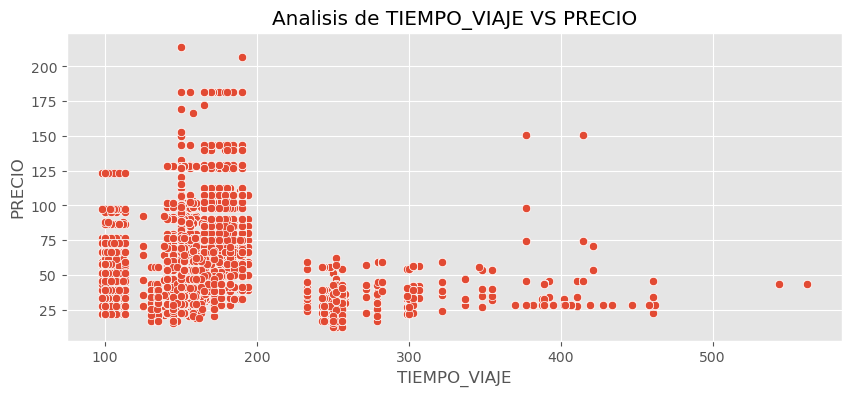


ANÁLISIS DE DIF_INIT_BUS CON RESPECTO AL PRECIO

                len    min   mean    max
             PRECIO PRECIO PRECIO PRECIO
DIF_INIT_BUS                            
30.88             1  76.30  76.30  76.30
64.92             1  67.20  67.20  67.20
98.12             1  76.30  76.30  76.30
106.70            1  49.15  49.15  49.15
135.22            1  76.30  76.30  76.30
...             ...    ...    ...    ...
86,032.10         1  43.55  43.55  43.55
86,032.97         1  49.15  49.15  49.15
86,063.92         1  43.55  43.55  43.55
86,070.45         1  45.80  45.80  45.80
86,106.63         1  45.80  45.80  45.80

[339670 rows x 4 columns]


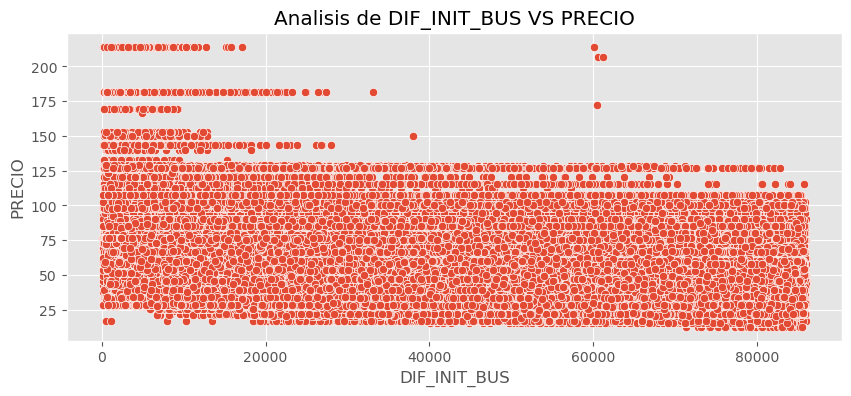


ANÁLISIS DE FECHA_CONSULTA_HORA CON RESPECTO AL PRECIO

                       len    min   mean    max
                    PRECIO PRECIO PRECIO PRECIO
FECHA_CONSULTA_HORA                            
0                     4457  12.85  63.13 214.20
1                    24706  12.85  60.88 214.20
2                     3772  15.45  62.31 214.20
3                    22214  12.85  60.57 214.20
4                     4280  16.60  64.15 214.20
5                    26568  12.85  61.21 214.20
6                     4005  15.45  62.33 214.20
7                    26668  12.85  61.18 214.20
8                     3436  15.45  64.23 214.20
9                    26434  12.85  61.22 214.20
10                    3829  16.60  63.52 214.20
11                   26732  12.85  61.06 214.20
12                    4477  16.60  62.95 214.20
13                   26760  12.85  60.81 214.20
14                    4033  15.45  63.96 214.20
15                   26343  12.85  61.11 214.20
16                    4180  16.

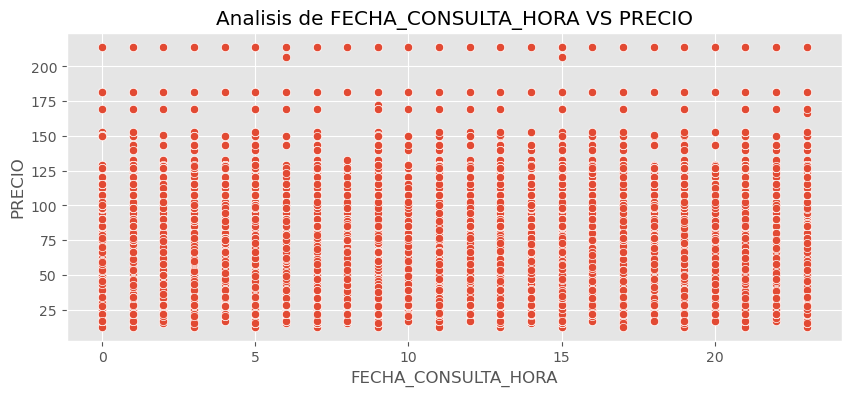


ANÁLISIS DE FECHA_CONSULTA_DIA CON RESPECTO AL PRECIO

                      len    min   mean    max
                   PRECIO PRECIO PRECIO PRECIO
FECHA_CONSULTA_DIA                            
1                   10364  12.85  60.13 214.20
2                   10761  12.85  60.29 214.20
3                    9969  12.85  61.05 214.20
4                    9007  12.85  60.37 214.20
5                    6418  15.45  63.26 214.20
6                    6376  15.45  63.59 214.20
7                    6901  15.45  64.77 214.20
8                    7251  12.85  63.71 214.20
9                    7838  12.85  63.10 214.20
10                   7385  12.85  62.67 214.20
11                   8243  15.45  62.06 214.20
12                  10075  15.45  62.92 214.20
13                  10538  12.85  62.70 214.20
14                  17847  15.45  61.15 214.20
15                  19549  15.45  60.69 214.20
16                  19061  15.45  60.93 214.20
17                  17900  15.45  60.46 181.50
18  

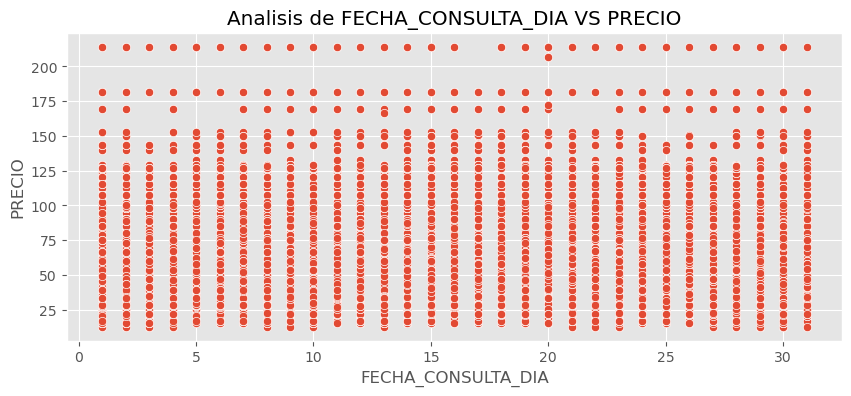


ANÁLISIS DE FECHA_INICIO_HORA CON RESPECTO AL PRECIO

                     len    min   mean    max
                  PRECIO PRECIO PRECIO PRECIO
FECHA_INICIO_HORA                            
2                   2104  45.80  46.67 150.60
5                   1816  32.30  62.47 129.30
6                  22839  12.85  49.58 181.50
7                  25958  21.95  67.59 214.20
8                  23951  12.85  62.56 214.20
9                  25616  18.65  57.34 181.50
10                 14295  15.70  63.25 181.50
11                 21292  16.60  59.19 181.50
12                 21961  21.95  60.61 181.50
13                 13428  20.15  63.70 181.50
14                 24151  17.10  54.90 214.20
15                 21509  16.60  65.85 214.20
16                 25403  21.30  66.44 214.20
17                 28722  12.85  62.08 214.20
18                 20869  16.75  73.71 214.20
19                 23174  18.65  66.80 214.20
20                 17831  20.15  60.80 214.20
21                 16775 

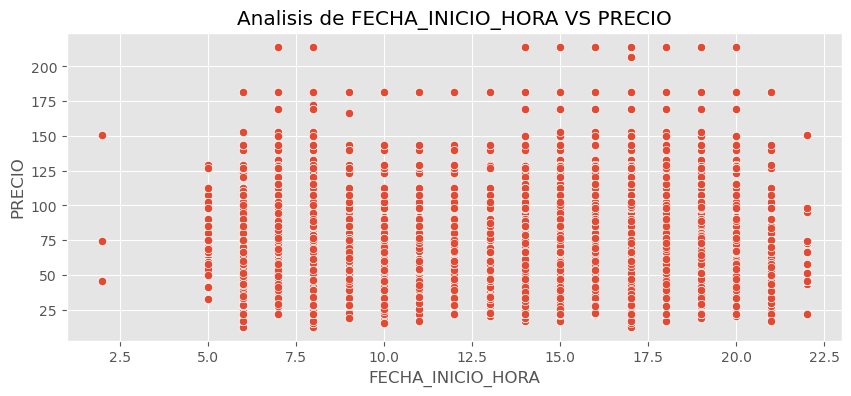


ANÁLISIS DE FECHA_INICIO_DIA CON RESPECTO AL PRECIO

                    len    min   mean    max
                 PRECIO PRECIO PRECIO PRECIO
FECHA_INICIO_DIA                            
1                 11162  12.85  60.36 206.80
2                 12404  12.85  60.87 214.20
3                 11094  15.45  59.45 181.50
4                 10842  15.70  59.32 181.50
5                 11114  15.45  63.14 214.20
6                 10548  15.45  59.80 214.20
7                 10898  12.85  61.99 214.20
8                 10948  15.45  59.44 214.20
9                 11567  15.70  60.25 214.20
10                11859  15.70  60.63 214.20
11                11173  12.85  59.10 214.20
12                11760  15.45  62.74 214.20
13                11410  15.45  59.83 214.20
14                11205  16.60  62.38 214.20
15                10584  12.85  58.68 181.50
16                11773  12.85  61.22 214.20
17                11673  12.85  61.95 181.50
18                10738  15.45  59.52 181.50
1

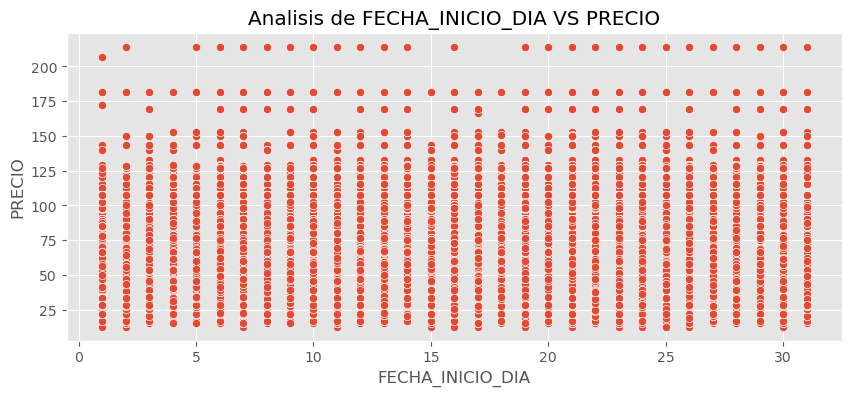


ANÁLISIS DE FECHA_INICIO_MES CON RESPECTO AL PRECIO

                    len    min   mean    max
                 PRECIO PRECIO PRECIO PRECIO
FECHA_INICIO_MES                            
4                 19937  16.60  71.46 214.20
5                 99711  15.45  63.96 214.20
6                 91187  15.70  65.10 214.20
7                 78802  12.85  58.12 181.50
8                 32638  12.85  54.14 181.50
9                 24778  16.60  54.22 129.30
10                 6902  12.85  44.90 107.70


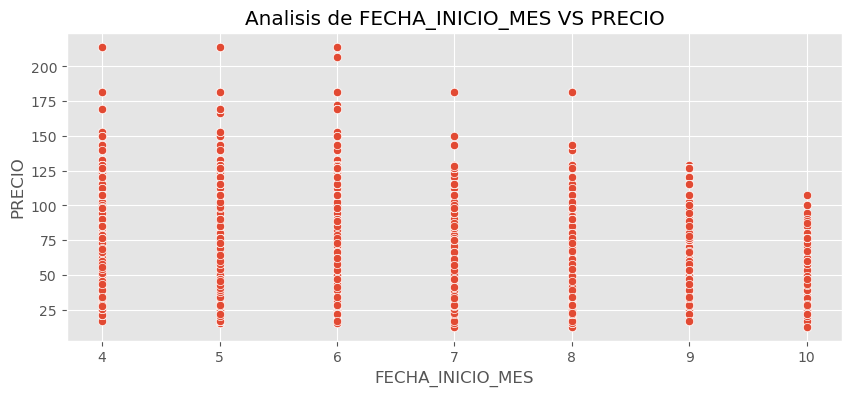


ANÁLISIS DE FECHA_FIN_HORA CON RESPECTO AL PRECIO

                  len    min   mean    max
               PRECIO PRECIO PRECIO PRECIO
FECHA_FIN_HORA                            
0                5258  28.10  56.64 181.50
4                2097  45.80  49.11 150.60
8                8746  21.93  58.60 152.50
9               26747  21.95  63.35 214.20
10              21039  12.85  62.35 214.20
11              21683  21.30  67.06 181.50
12              17209  12.85  54.92 181.50
13              21741  15.70  60.92 181.50
14              16795  21.95  53.26 181.50
15              16046  21.95  66.93 181.50
16              22604  20.15  59.49 214.20
17              25285  16.60  62.97 214.20
18              24995  17.10  63.08 214.20
19              27315  16.60  70.01 214.20
20              17105  21.93  69.02 214.20
21              30891  12.85  62.35 214.20
22              24122  17.15  54.22 214.20
23              24277  16.60  53.00 181.50


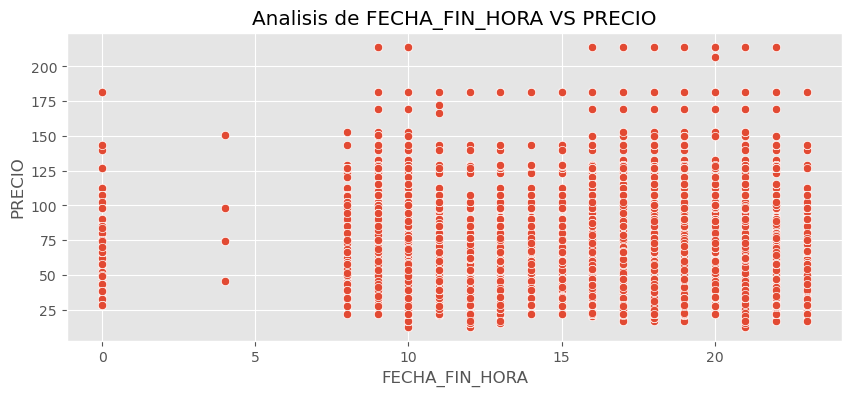


ANÁLISIS DE FECHA_FIN_DIA CON RESPECTO AL PRECIO

                 len    min   mean    max
              PRECIO PRECIO PRECIO PRECIO
FECHA_FIN_DIA                            
1              11172  12.85  60.46 206.80
2              12410  12.85  60.78 214.20
3              11105  15.45  59.55 181.50
4              10841  15.70  59.26 181.50
5              11103  15.45  63.09 214.20
6              10538  15.45  59.91 214.20
7              10871  12.85  61.97 214.20
8              10969  15.45  59.54 214.20
9              11569  15.70  60.16 214.20
10             11832  15.70  60.70 214.20
11             11206  12.85  59.07 214.20
12             11744  15.45  62.66 214.20
13             11415  15.45  59.95 214.20
14             11219  16.60  62.27 214.20
15             10595  12.85  58.78 181.50
16             11745  12.85  61.14 214.20
17             11695  12.85  62.01 181.50
18             10745  15.45  59.50 181.50
19             11338  12.85  63.69 214.20
20             11573  15.

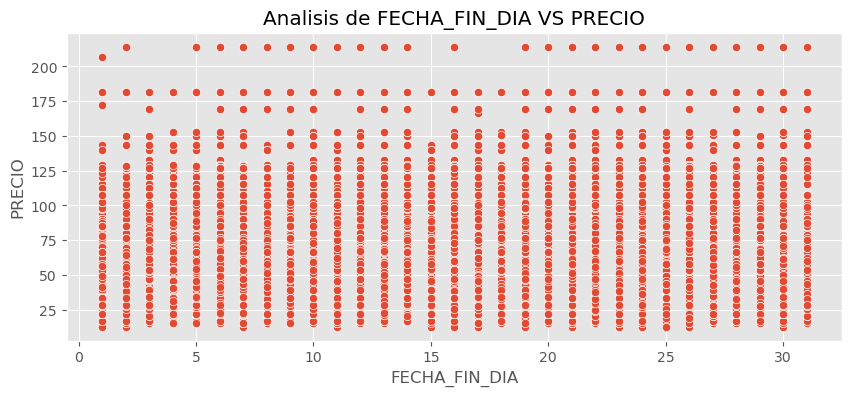


ANÁLISIS DE FECHA_FIN_MES CON RESPECTO AL PRECIO

                 len    min   mean    max
              PRECIO PRECIO PRECIO PRECIO
FECHA_FIN_MES                            
4              19907  16.60  71.48 214.20
5              99654  15.45  63.95 214.20
6              91207  15.70  65.11 214.20
7              78842  12.85  58.13 181.50
8              32650  12.85  54.14 181.50
9              24777  16.60  54.23 129.30
10              6918  12.85  44.90 107.70


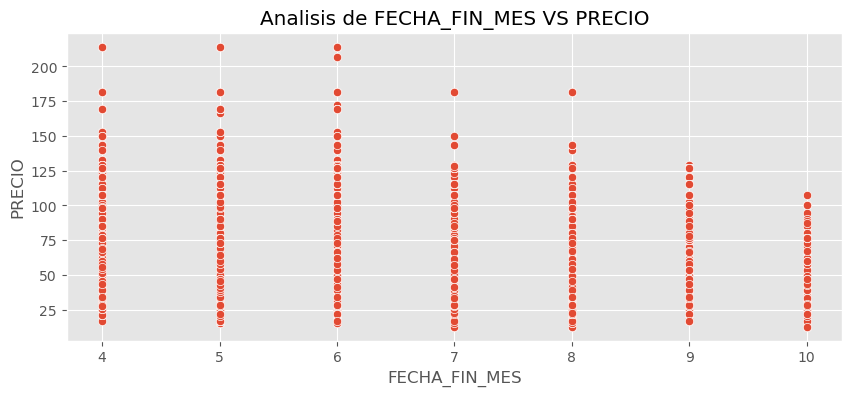

In [87]:
for var in list_num:
    print(analisis_numericas (dataframe = renfe_clean, column = var, target = 'PRECIO'))
    plot_numericas(dataframe = renfe_clean, column = var, target = 'PRECIO')

In [88]:
list_cat

['CIUDAD_ORIGEN',
 'CIUDAD_DESTINO',
 'TIPO_TREN',
 'TIPO_TARIFA',
 'CLASE',
 'FECHA_CONSULTA_NOMBREDIA',
 'FECHA_INICIO_NOMBREDIA',
 'FECHA_FIN_NOMBREDIA']


ANÁLISIS DE CIUDAD_ORIGEN CON RESPECTO AL PRECIO

                  len           sum   mean
               PRECIO        PRECIO PRECIO
CIUDAD_ORIGEN                             
MADRID         176520 10,979,104.77  62.20
BARCELONA       59720  5,113,282.50  85.62
SEVILLA         53031  3,021,888.62  56.98
VALENCIA        51959  2,075,495.48  39.94
PONFERRADA      12725    549,347.25  43.17


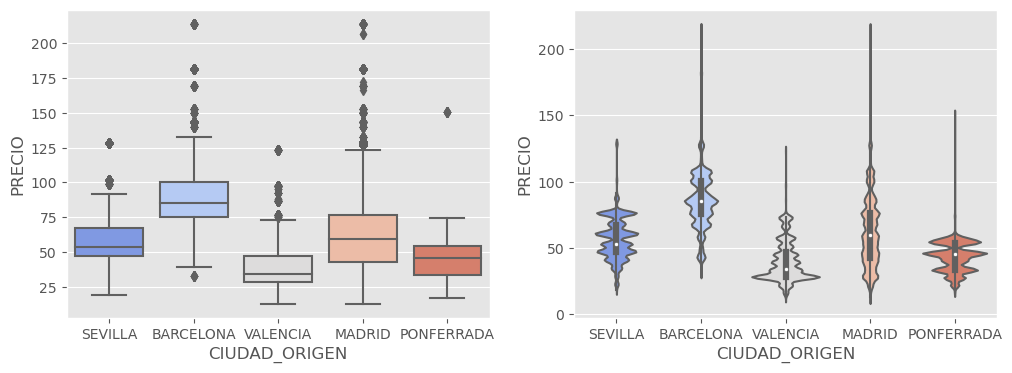


ANÁLISIS DE CIUDAD_DESTINO CON RESPECTO AL PRECIO

                   len           sum   mean
                PRECIO        PRECIO PRECIO
CIUDAD_DESTINO                             
MADRID          177435 10,760,013.85  60.64
BARCELONA        60583  5,243,591.87  86.55
VALENCIA         54587  2,263,285.06  41.46
SEVILLA          52972  3,095,044.34  58.43
PONFERRADA        8378    377,183.50  45.02


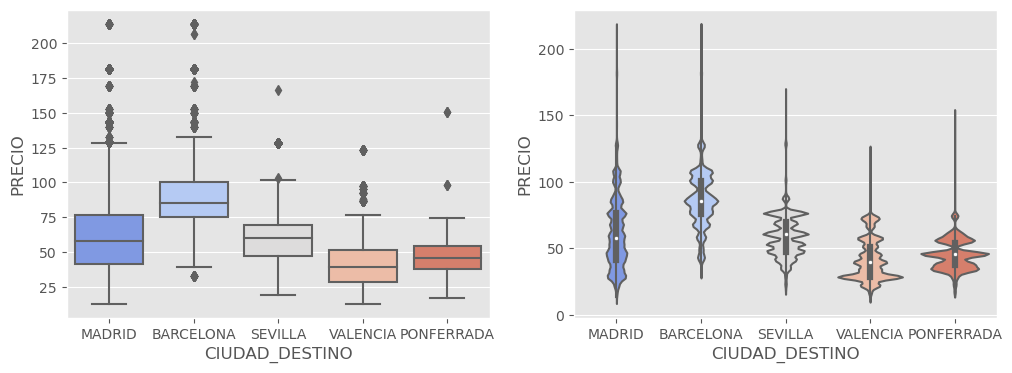


ANÁLISIS DE TIPO_TREN CON RESPECTO AL PRECIO

              len           sum   mean
           PRECIO        PRECIO PRECIO
TIPO_TREN                             
AVE        251592 17,098,814.29  67.96
ALVIA       21097  1,178,208.05  55.85
REGIONAL    18380    521,073.00  28.35
INTERCITY   18207    710,071.09  39.00
AV City     10226    483,365.97  47.27
MD-LD       10108    389,502.00  38.53
AVE-TGV      4907    443,846.32  90.45
R. EXPRES    4597    198,820.25  43.25
TRENHOTEL    4201    201,176.20  47.89
LD           4062    189,432.65  46.64
AVE-MD       3420    183,859.00  53.76
AVE-LD       3158    140,949.80  44.63


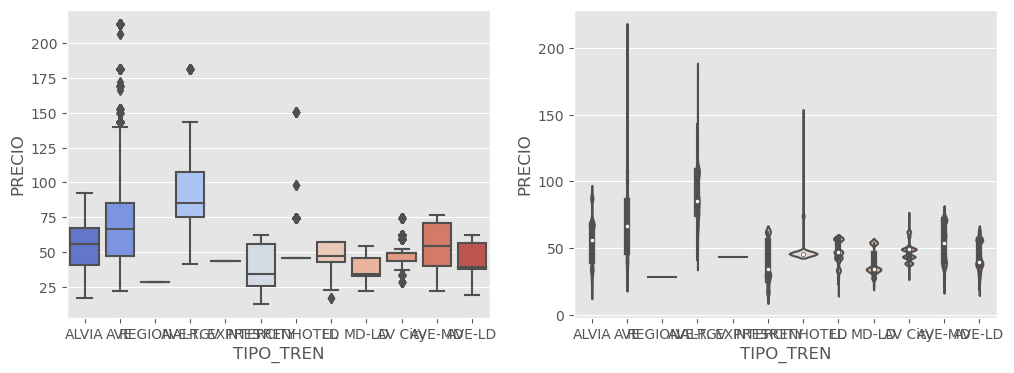


ANÁLISIS DE TIPO_TARIFA CON RESPECTO AL PRECIO

                len           sum   mean
             PRECIO        PRECIO PRECIO
TIPO_TARIFA                             
Promo        250892 14,960,772.12  59.63
Flexible      71367  5,736,089.30  80.37
Adulto ida    22977    719,893.25  31.33
Promo +        8537    310,223.45  36.34
Others          182     12,140.50  66.71


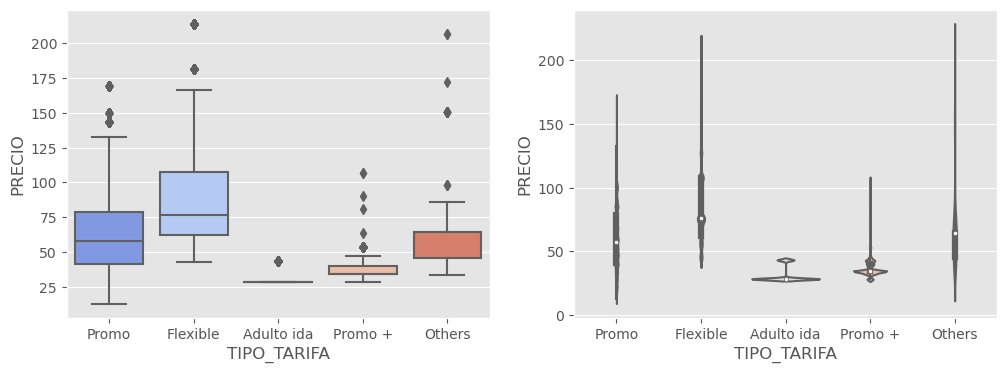


ANÁLISIS DE CLASE CON RESPECTO AL PRECIO

                       len           sum   mean
                    PRECIO        PRECIO PRECIO
CLASE                                          
Turista             270609 15,832,119.70  58.51
Preferente           34052  2,601,716.18  76.40
Turista Plus         25884  2,171,093.34  83.88
Turista con enlace   20748    903,743.45  43.56
Others                2662    230,445.95  86.57


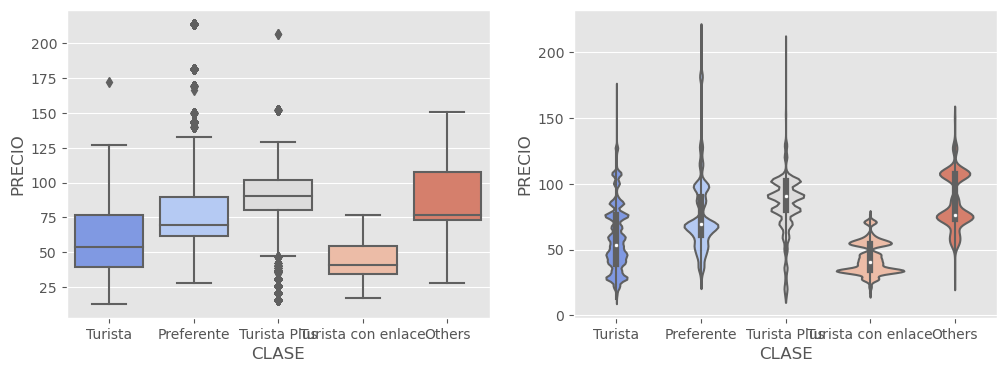


ANÁLISIS DE FECHA_CONSULTA_NOMBREDIA CON RESPECTO AL PRECIO

                            len          sum   mean
                         PRECIO       PRECIO PRECIO
FECHA_CONSULTA_NOMBREDIA                           
Sunday                    55499 3,419,568.39  61.61
Wednesday                 52100 3,183,059.81  61.10
Thursday                  51576 3,159,772.02  61.26
Friday                    49664 3,050,144.30  61.42
Tuesday                   48946 3,009,581.21  61.49
Monday                    48809 3,018,264.78  61.84
Saturday                  47361 2,898,728.11  61.20


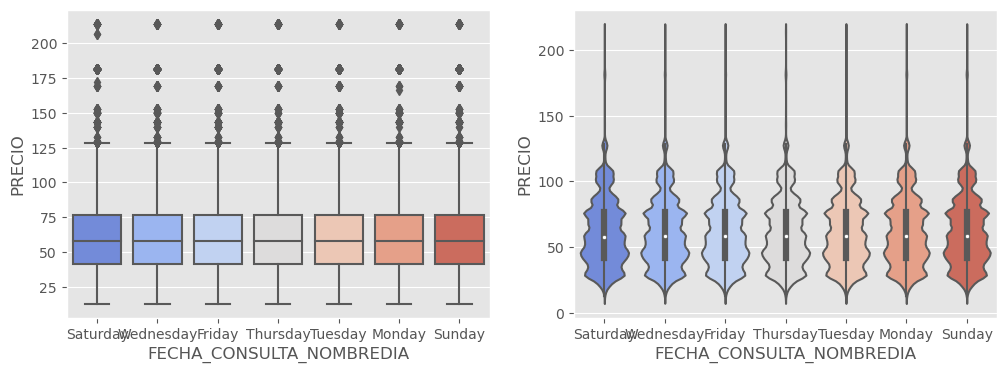


ANÁLISIS DE FECHA_INICIO_NOMBREDIA CON RESPECTO AL PRECIO

                          len          sum   mean
                       PRECIO       PRECIO PRECIO
FECHA_INICIO_NOMBREDIA                           
Thursday                55757 3,382,445.27  60.66
Tuesday                 53780 3,105,203.35  57.74
Wednesday               53606 3,161,435.31  58.98
Monday                  53163 3,243,457.98  61.01
Friday                  53044 3,486,754.34  65.73
Sunday                  47125 3,200,160.03  67.91
Saturday                37480 2,159,662.34  57.62


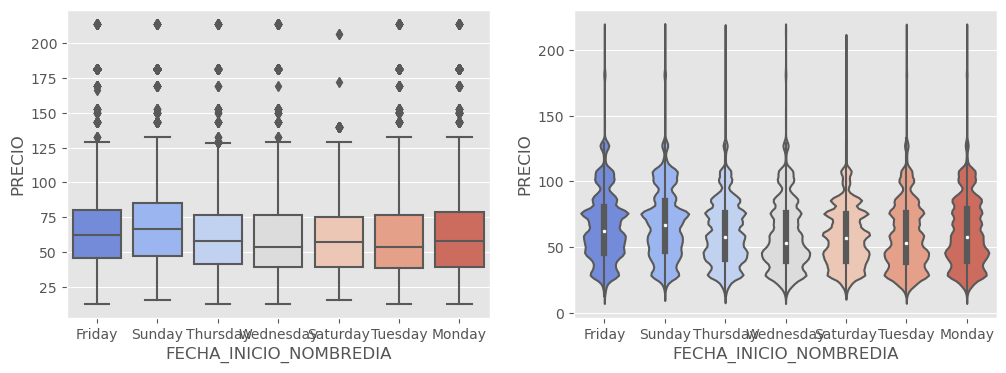


ANÁLISIS DE FECHA_FIN_NOMBREDIA CON RESPECTO AL PRECIO

                       len          sum   mean
                    PRECIO       PRECIO PRECIO
FECHA_FIN_NOMBREDIA                           
Thursday             55723 3,376,480.11  60.59
Tuesday              53821 3,110,668.18  57.80
Wednesday            53640 3,161,007.41  58.93
Monday               53084 3,252,174.15  61.26
Friday               53066 3,484,145.68  65.66
Sunday               46871 3,173,355.67  67.70
Saturday             37750 2,181,287.42  57.78


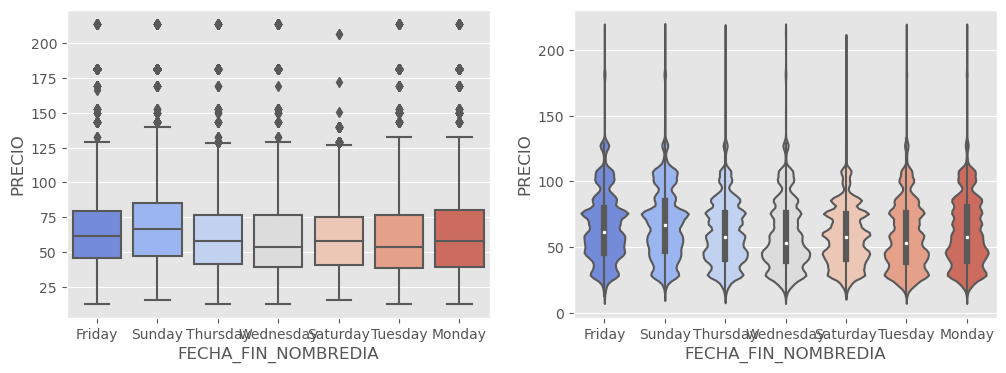

In [89]:
for var in list_cat:
    print(analisis_categoricas (dataframe = renfe_clean, column = var, target = 'PRECIO'))
    plot_categoricas(dataframe = renfe_clean, column = var, target = 'PRECIO')

- FECHA_INICIO_NOMBREDIA VS PRECIO --  El sábado es el día con los precios más elevados. El miércoles, el más barato.
- FECHA_CONSULTA_NOMBREDIA VS PRECIO -- Prácticamente no hay relevancia.
- CIUDAD_ORIGEN VS PRECIO  -- El origen de la ciudad tiene gran influencia en el precio ... Siendo Barcelona la que tiene los precios más elevados y Valencia los más baratos.
- TIPO_TREN VS PRECIO -- El tipo de tren también tiene relevancia en el precio. Los más caros son los AVE y los Alvia.
- CLASE VS PRECIO  -- La clase también tiene relevancia. La más cara es la turista plus y la más barata es la turista con enlace.


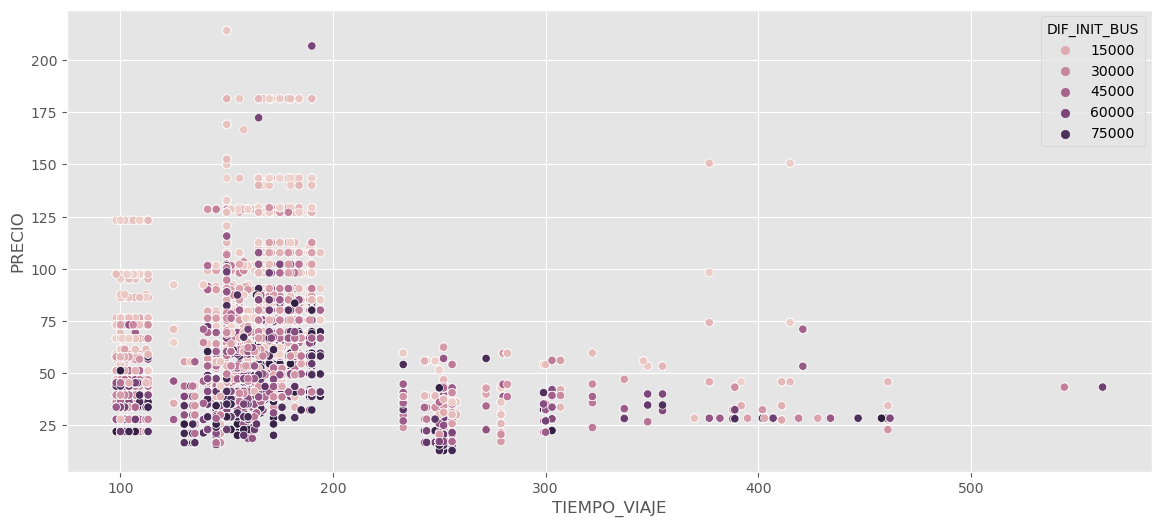

In [90]:
plt.figure(figsize=(14,6))
sns.scatterplot(x='TIEMPO_VIAJE', y='PRECIO',hue='DIF_INIT_BUS', data= renfe_clean);

- Para viajes de corta duración (inferiores a 200 minutos) el precio varía mucho y para viajes largos (más de 200 minutos), el precio apenas varía.
- Si además añadimos la variable DIF_INIT_BUS ... vemos que esa variabilidad del precio en los trayectos cortos se debe a la próximidad entre la búsqueda y el inicio del viaje (cuánto más cercana sea la busqueda con respecto al inicio del viaje, mayor será el precio).

### 2.3. ELIMINAR VARIABLES QUE NO TIENEN RELEVANCIA

Elimino las variables que a criterio de negocio no tienen relevancia.

In [91]:
renfe_clean.drop(['FECHA_CONSULTA_HORA', 'FECHA_CONSULTA_DIA', 'FECHA_CONSULTA_NOMBREDIA'], axis = 1, inplace = True)

In [92]:
# Actualizao variables
list_num, list_bool, list_cat = obtener_lista_variables (renfe_clean)

## **3.- DATA PREPARATION**

### 3.1.- IMPUTACIÓN DE NULOS

Hecho en el apartado 2

In [93]:
nulos_variable (renfe_clean)

Las variables numéricas que tienen nulos son:
 Series([], dtype: int64) 

Hay un total de 0 variables numéricas con nulos


Las variables categóricas que tienen nulos son:
 Series([], dtype: int64) 

Hay un total de 0 variables categóricas con nulos


VARIABLES TOTALES CON NULOS: 0


### 3.2.- TRATAMIENTO DE VARIABLES CATEGÓRICAS

Nuestro objetivo es predecir el precio de los viajes en tren.\
Todas las variables que le pasemos al modelo deben ser numéricas.\
Hay que transfomar las variables categóricas en numéricas.

In [94]:
list_cat

['CIUDAD_ORIGEN',
 'CIUDAD_DESTINO',
 'TIPO_TREN',
 'TIPO_TARIFA',
 'CLASE',
 'FECHA_INICIO_NOMBREDIA',
 'FECHA_FIN_NOMBREDIA']

Estrategias a seguir:
- list_cat --> OHE (one hot encoding)
- ESTANDARIZAMOS --> MixMaxScaler

In [95]:
# OHE --> genera las nuevas variables y elimina al mismo tiempo las antiguas
renfe_preprocess = pd.get_dummies(data = renfe_clean, prefix=None, prefix_sep="_", columns = list_cat, drop_first = False)
renfe_preprocess.head(10).T

,0,1,2,3,4,5,6,7,8,9
TIEMPO_VIAJE,158.00,190.00,150.00,460.00,179.00,158.00,100.00,190.00,562.00,407.00
DIF_INIT_BUS,"50,092.95","31,494.82","52,275.95","26,968.02","68,741.38","65,396.73","1,692.62","2,743.28","44,127.27","60,230.58"
FECHA_INICIO_HORA,20.00,10.00,13.00,14.00,13.00,9.00,12.00,17.00,7.00,6.00
FECHA_INICIO_DIA,28.00,14.00,23.00,29.00,26.00,5.00,16.00,1.00,12.00,27.00
FECHA_INICIO_MES,6.00,7.00,5.00,5.00,6.00,10.00,4.00,6.00,6.00,5.00
FECHA_FIN_HORA,23.00,13.00,16.00,22.00,16.00,11.00,14.00,20.00,16.00,12.00
FECHA_FIN_DIA,28.00,14.00,23.00,29.00,26.00,5.00,16.00,1.00,12.00,27.00
FECHA_FIN_MES,6.00,7.00,5.00,5.00,6.00,10.00,4.00,6.00,6.00,5.00
PRECIO,67.20,107.70,47.30,28.35,66.75,69.35,51.15,66.75,43.25,28.35
LOG_PRECIO,1.83,2.03,1.67,1.45,1.82,1.84,1.71,1.82,1.64,1.45


### 3.3.- TRATAMIENTO DE VARIABLES NUMERICAS

Vemos si hay alguna correlación entre las variables

In [96]:
corr = renfe_preprocess.corr()
corr.style.background_gradient(cmap="coolwarm")

,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_INICIO_HORA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_DIA,FECHA_FIN_MES,PRECIO,LOG_PRECIO,CIUDAD_ORIGEN_BARCELONA,CIUDAD_ORIGEN_MADRID,CIUDAD_ORIGEN_PONFERRADA,CIUDAD_ORIGEN_SEVILLA,CIUDAD_ORIGEN_VALENCIA,CIUDAD_DESTINO_BARCELONA,CIUDAD_DESTINO_MADRID,CIUDAD_DESTINO_PONFERRADA,CIUDAD_DESTINO_SEVILLA,CIUDAD_DESTINO_VALENCIA,TIPO_TREN_ALVIA,TIPO_TREN_AV City,TIPO_TREN_AVE,TIPO_TREN_AVE-LD,TIPO_TREN_AVE-MD,TIPO_TREN_AVE-TGV,TIPO_TREN_INTERCITY,TIPO_TREN_LD,TIPO_TREN_MD-LD,TIPO_TREN_R. EXPRES,TIPO_TREN_REGIONAL,TIPO_TREN_TRENHOTEL,TIPO_TARIFA_Promo,TIPO_TARIFA_Flexible,TIPO_TARIFA_Adulto ida,TIPO_TARIFA_Promo +,TIPO_TARIFA_Others,CLASE_Turista,CLASE_Preferente,CLASE_Turista Plus,CLASE_Turista con enlace,CLASE_Others,FECHA_INICIO_NOMBREDIA_Friday,FECHA_INICIO_NOMBREDIA_Monday,FECHA_INICIO_NOMBREDIA_Saturday,FECHA_INICIO_NOMBREDIA_Sunday,FECHA_INICIO_NOMBREDIA_Thursday,FECHA_INICIO_NOMBREDIA_Tuesday,FECHA_INICIO_NOMBREDIA_Wednesday,FECHA_FIN_NOMBREDIA_Friday,FECHA_FIN_NOMBREDIA_Monday,FECHA_FIN_NOMBREDIA_Saturday,FECHA_FIN_NOMBREDIA_Sunday,FECHA_FIN_NOMBREDIA_Thursday,FECHA_FIN_NOMBREDIA_Tuesday,FECHA_FIN_NOMBREDIA_Wednesday
TIEMPO_VIAJE,1.000000,0.022050,-0.177650,-0.006672,0.001585,0.092365,-0.006470,0.001791,-0.238879,-0.275134,0.012013,-0.042658,0.251031,-0.096234,0.012552,-0.007178,0.042658,0.172423,-0.095026,-0.030285,-0.027730,-0.024510,-0.624830,0.100649,0.148034,-0.009959,-0.033869,0.128110,0.314070,0.455923,0.603596,0.250806,-0.535210,0.028729,0.753101,0.300714,-0.002634,-0.115060,-0.118934,-0.021358,0.382709,-0.005221,-0.004705,0.003699,-0.000194,-0.000064,-0.003637,0.005596,-0.000682,-0.004065,0.003079,0.006301,-0.006427,-0.003120,0.004926,-0.000132
DIF_INIT_BUS,0.022050,1.000000,0.003236,-0.030047,0.451128,0.009267,-0.030431,0.451214,-0.241765,-0.246375,-0.025563,-0.000648,-0.005448,0.011557,0.019178,-0.029791,0.000648,-0.022721,0.013536,0.026365,0.044710,0.004367,-0.047562,-0.013966,-0.029286,-0.004702,0.030260,-0.007921,-0.030569,0.007370,0.055191,0.010584,0.166690,-0.208625,0.053091,-0.032742,-0.003596,0.105280,-0.067150,-0.020864,-0.043052,-0.107920,0.008138,-0.017450,0.008857,0.022290,-0.000624,-0.016566,-0.002216,0.007590,-0.016349,0.009158,0.021594,-0.000578,-0.016605,-0.002358
FECHA_INICIO_HORA,-0.177650,0.003236,1.000000,0.002823,-0.003761,0.718555,0.002786,-0.002936,0.049913,0.044464,-0.028696,0.077521,-0.113411,0.016918,-0.036557,-0.016964,-0.077521,0.110952,0.033262,0.045458,-0.009663,0.018162,0.075179,0.038544,0.034998,-0.019396,0.044285,-0.029515,0.006510,-0.124390,-0.135273,-0.029963,0.048374,0.051204,-0.178986,0.010435,-0.001012,-0.066371,0.038109,0.033454,0.021236,0.037332,0.025228,-0.033400,-0.018005,0.118409,-0.024394,-0.036791,-0.026961,0.025608,-0.034575,-0.013451,0.114809,-0.024938,-0.036198,-0.026435
FECHA_INICIO_DIA,-0.006672,-0.030047,0.002823,1.000000,-0.294087,0.001530,0.996098,-0.293288,0.032580,0.033630,-0.002812,0.007617,-0.002223,-0.006115,-0.000449,0.005292,-0.007617,0.011182,-0.002896,0.003180,-0.004174,-0.000230,0.003486,0.004946,0.004574,0.000504,0.004541,0.001718,-0.001115,-0.002853,-0.007316,-0.005349,-0.011659,0.015836,-0.007900,0.005659,0.000944,-0.001469,0.001032,-0.001859,0.003874,-0.001238,0.045713,-0.034419,-0.019021,-0.002234,0.009326,0.000544,-0.002794,0.044724,-0.033417,-0.017144,-0.003129,0.009012,0.000059,-0.002750
FECHA_INICIO_MES,0.001585,0.451128,-0.003761,-0.294087,1.000000,-0.004272,-0.293181,0.999825,-0.187495,-0.184722,-0.043681,-0.022416,0.006374,0.043663,0.030509,-0.069954,0.022416,-0.020472,0.036638,0.014349,0.067424,0.015376,-0.057618,-0.016881,-0.035912,-0.006550,0.042371,-0.004757,-0.007003,0.003586,0.013395,0.022040,0.088648,-0.097897,0.013711,-0.028433,-0.000511,0.059381,-0.025197,-0.041251,-0.028834,-0.002915,-0.005886,-0.002153,0.010992,0.006488,0.000293,-0.009890,0.002029,-0.006228,-0.002048,0.011526,0.005508,0.000544,-0.009838,0.002411
FECHA_FIN_HORA,0.092365,0.009267,0.718555,0.001530,-0.004272,1.000000,

In [97]:
corr_yes = corr[(corr<=-.85)|(corr[corr>=.85])] 
corr_yes.style.background_gradient(cmap="coolwarm")

,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_INICIO_HORA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_DIA,FECHA_FIN_MES,PRECIO,LOG_PRECIO,CIUDAD_ORIGEN_BARCELONA,CIUDAD_ORIGEN_MADRID,CIUDAD_ORIGEN_PONFERRADA,CIUDAD_ORIGEN_SEVILLA,CIUDAD_ORIGEN_VALENCIA,CIUDAD_DESTINO_BARCELONA,CIUDAD_DESTINO_MADRID,CIUDAD_DESTINO_PONFERRADA,CIUDAD_DESTINO_SEVILLA,CIUDAD_DESTINO_VALENCIA,TIPO_TREN_ALVIA,TIPO_TREN_AV City,TIPO_TREN_AVE,TIPO_TREN_AVE-LD,TIPO_TREN_AVE-MD,TIPO_TREN_AVE-TGV,TIPO_TREN_INTERCITY,TIPO_TREN_LD,TIPO_TREN_MD-LD,TIPO_TREN_R. EXPRES,TIPO_TREN_REGIONAL,TIPO_TREN_TRENHOTEL,TIPO_TARIFA_Promo,TIPO_TARIFA_Flexible,TIPO_TARIFA_Adulto ida,TIPO_TARIFA_Promo +,TIPO_TARIFA_Others,CLASE_Turista,CLASE_Preferente,CLASE_Turista Plus,CLASE_Turista con enlace,CLASE_Others,FECHA_INICIO_NOMBREDIA_Friday,FECHA_INICIO_NOMBREDIA_Monday,FECHA_INICIO_NOMBREDIA_Saturday,FECHA_INICIO_NOMBREDIA_Sunday,FECHA_INICIO_NOMBREDIA_Thursday,FECHA_INICIO_NOMBREDIA_Tuesday,FECHA_INICIO_NOMBREDIA_Wednesday,FECHA_FIN_NOMBREDIA_Friday,FECHA_FIN_NOMBREDIA_Monday,FECHA_FIN_NOMBREDIA_Saturday,FECHA_FIN_NOMBREDIA_Sunday,FECHA_FIN_NOMBREDIA_Thursday,FECHA_FIN_NOMBREDIA_Tuesday,FECHA_FIN_NOMBREDIA_Wednesday
TIEMPO_VIAJE,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
DIF_INIT_BUS,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FECHA_INICIO_HORA,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FECHA_INICIO_DIA,nan,nan,nan,1.000000,nan,nan,0.996098,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FECHA_INICIO_MES,nan,nan,nan,nan,1.000000,nan,nan,0.999825,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FECHA_FIN_HORA,nan,nan,nan,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FECHA_FIN_DIA,nan,nan,nan,0.996098,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
FECHA_FIN_MES,nan,nan,nan,nan,0.999825,nan,nan,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
PRECIO,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,0.966718,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LOG_PRECIO,nan,nan,nan,nan,nan,nan,nan,nan,0.966718,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Existe correlación elevada:
- FECHA_FIN_DIA y FECHA_INICIO_DIA
- FECHA_FIN_MES y FECHA_INICIO_MES
- CIUDAD_ORIGEN_MADRID Y CIUDAD_DESTINO_MADRID
- TIPO_TARIFA_Adulto ida Y TIPO_TREN_REGIONAL
- FECHA_INICIO_NOMBREDIA_Friday Y FECHA_FIN_NOMBREDIA_Friday
- FECHA_INICIO_NOMBREDIA_Monday Y FECHA_FIN_NOMBREDIA_Monda
- FECHA_INICIO_NOMBREDIA_Saturday Y FECHA_FIN_NOMBREDIA_Saturday
- FECHA_INICIO_NOMBREDIA_Sunday Y FECHA_FIN_NOMBREDIA_Sunday
- FECHA_INICIO_NOMBREDIA_Thursday Y FECHA_FIN_NOMBREDIA_Thursday
- FECHA_INICIO_NOMBREDIA_Tuesday Y FECHA_FIN_NOMBREDIA_Tuesday
- FECHA_INICIO_NOMBREDIA_Wednesday Y FECHA_FIN_NOMBREDIA_Wednesday

In [98]:
renfe_preprocess[['FECHA_FIN_DIA', 'FECHA_INICIO_DIA', 
                  'FECHA_FIN_MES', 'FECHA_INICIO_MES',
                  'CIUDAD_ORIGEN_MADRID', 'CIUDAD_DESTINO_MADRID',
                  'TIPO_TARIFA_Adulto ida', 'TIPO_TREN_REGIONAL',
                  'FECHA_INICIO_NOMBREDIA_Friday', 'FECHA_FIN_NOMBREDIA_Friday',
                  'FECHA_INICIO_NOMBREDIA_Monday', 'FECHA_FIN_NOMBREDIA_Monday',
                  'FECHA_INICIO_NOMBREDIA_Saturday', 'FECHA_FIN_NOMBREDIA_Saturday',
                  'FECHA_INICIO_NOMBREDIA_Sunday', 'FECHA_FIN_NOMBREDIA_Sunday',
                  'FECHA_INICIO_NOMBREDIA_Thursday', 'FECHA_FIN_NOMBREDIA_Thursday',
                  'FECHA_INICIO_NOMBREDIA_Tuesday', 'FECHA_FIN_NOMBREDIA_Tuesday',
                  'FECHA_INICIO_NOMBREDIA_Wednesday', 'FECHA_FIN_NOMBREDIA_Wednesday']].corr()

,FECHA_FIN_DIA,FECHA_INICIO_DIA,FECHA_FIN_MES,FECHA_INICIO_MES,CIUDAD_ORIGEN_MADRID,CIUDAD_DESTINO_MADRID,TIPO_TARIFA_Adulto ida,TIPO_TREN_REGIONAL,FECHA_INICIO_NOMBREDIA_Friday,FECHA_FIN_NOMBREDIA_Friday,FECHA_INICIO_NOMBREDIA_Monday,FECHA_FIN_NOMBREDIA_Monday,FECHA_INICIO_NOMBREDIA_Saturday,FECHA_FIN_NOMBREDIA_Saturday,FECHA_INICIO_NOMBREDIA_Sunday,FECHA_FIN_NOMBREDIA_Sunday,FECHA_INICIO_NOMBREDIA_Thursday,FECHA_FIN_NOMBREDIA_Thursday,FECHA_INICIO_NOMBREDIA_Tuesday,FECHA_FIN_NOMBREDIA_Tuesday,FECHA_INICIO_NOMBREDIA_Wednesday,FECHA_FIN_NOMBREDIA_Wednesday
FECHA_FIN_DIA,1.00,1.00,-0.29,-0.29,0.01,-0.01,-0.01,-0.01,0.04,0.05,-0.03,-0.03,-0.02,-0.02,-0.00,-0.00,0.01,0.01,0.00,0.00,-0.00,-0.00
FECHA_INICIO_DIA,1.00,1.00,-0.29,-0.29,0.01,-0.01,-0.01,-0.01,0.05,0.04,-0.03,-0.03,-0.02,-0.02,-0.00,-0.00,0.01,0.01,0.00,0.00,-0.00,-0.00
FECHA_FIN_MES,-0.29,-0.29,1.00,1.00,-0.02,0.02,0.01,0.01,-0.01,-0.01,-0.00,-0.00,0.01,0.01,0.01,0.01,0.00,0.00,-0.01,-0.01,0.00,0.00
FECHA_INICIO_MES,-0.29,-0.29,1.00,1.00,-0.02,0.02,0.01,0.01,-0.01,-0.01,-0.00,-0.00,0.01,0.01,0.01,0.01,0.00,0.00,-0.01,-0.01,0.00,0.00
CIUDAD_ORIGEN_MADRID,0.01,0.01,-0.02,-0.02,1.00,-1.00,-0.00,0.00,0.01,0.01,0.00,0.00,-0.01,-0.01,0.01,0.01,-0.00,-0.00,0.00,0.00,-0.00,-0.00
CIUDAD_DESTINO_MADRID,-0.01,-0.01,0.02,0.02,-1.00,1.00,0.00,-0.00,-0.01,-0.01,-0.00,-0.00,0.01,0.01,-0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,0.00
TIPO_TARIFA_Adulto ida,-0.01,-0.01,0.01,0.01,-0.00,0.00,1.00,0.89,-0.00,-0.00,0.00,0.00,-0.01,-0.01,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
TIPO_TREN_REGIONAL,-0.01,-0.01,0.01,0.01,0.00,-0.00,0.89,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01,0.01,-0.00,-0.00,0.00,0.00,-0.00,-0.00
FECHA_INICIO_NOMBREDIA_Friday,0.04,0.05,-0.01,-0.01,0.01,-0.01,-0.00,-0.00,1.00,0.98,-0.18,-0.18,-0.14,-0.12,-0.16,-0.16,-0.18,-0.18,-0.18,-0.18,-0.18,-0.18
FECHA_FIN_NOMBREDIA_Friday,0.05,0.04,-0.01,-0.01,0.01,-0.01,-0.00,-0.00,0.98,1.00,-0.18,-0.18,-0.14,-0.15,-0.16,-0.16,-0.16,-0.18,-0.18,-0.18,-0.18,-0.18


Otra forma de hacerlo

In [99]:
np.ones(corr.shape)

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [100]:
np.triu(np.ones(corr.shape), k=-1).astype(bool)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False,  True,  True]])

In [101]:
# np.triu me devuelve una matriz triangular superior con unos. Siendo nulos los valores por debajo de la diagonal k-ésima. 
# astype(bool) me devuelve una matriz de True (si el valor es booleano) y False.
# Where me devuelve los valores que son True de corr y el resto son nulos.
corr2=corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr2

,TIEMPO_VIAJE,DIF_INIT_BUS,FECHA_INICIO_HORA,FECHA_INICIO_DIA,FECHA_INICIO_MES,FECHA_FIN_HORA,FECHA_FIN_DIA,FECHA_FIN_MES,PRECIO,LOG_PRECIO,CIUDAD_ORIGEN_BARCELONA,CIUDAD_ORIGEN_MADRID,CIUDAD_ORIGEN_PONFERRADA,CIUDAD_ORIGEN_SEVILLA,CIUDAD_ORIGEN_VALENCIA,CIUDAD_DESTINO_BARCELONA,CIUDAD_DESTINO_MADRID,CIUDAD_DESTINO_PONFERRADA,CIUDAD_DESTINO_SEVILLA,CIUDAD_DESTINO_VALENCIA,TIPO_TREN_ALVIA,TIPO_TREN_AV City,TIPO_TREN_AVE,TIPO_TREN_AVE-LD,TIPO_TREN_AVE-MD,TIPO_TREN_AVE-TGV,TIPO_TREN_INTERCITY,TIPO_TREN_LD,TIPO_TREN_MD-LD,TIPO_TREN_R. EXPRES,TIPO_TREN_REGIONAL,TIPO_TREN_TRENHOTEL,TIPO_TARIFA_Promo,TIPO_TARIFA_Flexible,TIPO_TARIFA_Adulto ida,TIPO_TARIFA_Promo +,TIPO_TARIFA_Others,CLASE_Turista,CLASE_Preferente,CLASE_Turista Plus,CLASE_Turista con enlace,CLASE_Others,FECHA_INICIO_NOMBREDIA_Friday,FECHA_INICIO_NOMBREDIA_Monday,FECHA_INICIO_NOMBREDIA_Saturday,FECHA_INICIO_NOMBREDIA_Sunday,FECHA_INICIO_NOMBREDIA_Thursday,FECHA_INICIO_NOMBREDIA_Tuesday,FECHA_INICIO_NOMBREDIA_Wednesday,FECHA_FIN_NOMBREDIA_Friday,FECHA_FIN_NOMBREDIA_Monday,FECHA_FIN_NOMBREDIA_Saturday,FECHA_FIN_NOMBREDIA_Sunday,FECHA_FIN_NOMBREDIA_Thursday,FECHA_FIN_NOMBREDIA_Tuesday,FECHA_FIN_NOMBREDIA_Wednesday
TIEMPO_VIAJE,NaN,0.02,-0.18,-0.01,0.00,0.09,-0.01,0.00,-0.24,-0.28,0.01,-0.04,0.25,-0.10,0.01,-0.01,0.04,0.17,-0.10,-0.03,-0.03,-0.02,-0.62,0.10,0.15,-0.01,-0.03,0.13,0.31,0.46,0.60,0.25,-0.54,0.03,0.75,0.30,-0.00,-0.12,-0.12,-0.02,0.38,-0.01,-0.00,0.00,-0.00,-0.00,-0.00,0.01,-0.00,-0.00,0.00,0.01,-0.01,-0.00,0.00,-0.00
DIF_INIT_BUS,NaN,NaN,0.00,-0.03,0.45,0.01,-0.03,0.45,-0.24,-0.25,-0.03,-0.00,-0.01,0.01,0.02,-0.03,0.00,-0.02,0.01,0.03,0.04,0.00,-0.05,-0.01,-0.03,-0.00,0.03,-0.01,-0.03,0.01,0.06,0.01,0.17,-0.21,0.05,-0.03,-0.00,0.11,-0.07,-0.02,-0.04,-0.11,0.01,-0.02,0.01,0.02,-0.00,-0.02,-0.00,0.01,-0.02,0.01,0.02,-0.00,-0.02,-0.00
FECHA_INICIO_HORA,NaN,NaN,NaN,0.00,-0.00,0.72,0.00,-0.00,0.05,0.04,-0.03,0.08,-0.11,0.02,-0.04,-0.02,-0.08,0.11,0.03,0.05,-0.01,0.02,0.08,0.04,0.03,-0.02,0.04,-0.03,0.01,-0.12,-0.14,-0.03,0.05,0.05,-0.18,0.01,-0.00,-0.07,0.04,0.03,0.02,0.04,0.03,-0.03,-0.02,0.12,-0.02,-0.04,-0.03,0.03,-0.03,-0.01,0.11,-0.02,-0.04,-0.03
FECHA_INICIO_DIA,NaN,NaN,NaN,NaN,-0.29,0.00,1.00,-0.29,0.03,0.03,-0.00,0.01,-0.00,-0.01,-0.00,0.01,-0.01,0.01,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.01,-0.01,0.02,-0.01,0.01,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.05,-0.03,-0.02,-0.00,0.01,0.00,-0.00,0.04,-0.03,-0.02,-0.00,0.01,0.00,-0.00
FECHA_INICIO_MES,NaN,NaN,NaN,NaN,NaN,-0.00,-0.29,1.00,-0.19,-0.18,-0.04,-0.02,0.01,0.04,0.03,-0.07,0.02,-0.02,0.04,0.01,0.07,0.02,-0.06,-0.02,-0.04,-0.01,0.04,-0.00,-0.01,0.00,0.01,0.02,0.09,-0.10,0.01,-0.03,-0.00,0.06,-0.03,-0.04,-0.03,-0.00,-0.01,-0.00,0.01,0.01,0.00,-0.01,0.00,-0.01,-0.00,0.01,0.01,0.00,-0.01,0.00
FECHA_FIN_HORA,NaN,NaN,NaN,NaN,NaN,NaN,0.00,-0.01,-0.01,-0.04,-0.08,0.02,0.00,0.05,0.00,0.02,-0.02,-0.01,-0.07,0.09,0.02,-0.19,-0.05,0.08,0.09,-0.01,0.05,0.03,0.11,0.03,0.09,-0.20,-0.11,0.03,0.09,0.11,-0.00,-0.12,0.03,0.02,0.16,0.00,0.02,-0.03,-0.02,0.11,-0.02,-0.03,-0.02,0.02,-0.03,-0.02,0.11,-0.02,-0.03,-0.02
FECHA_FIN_DIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.29,0.03,0.03,-0.00,0.01,-0.00,-0.01,-0.00,0.01,-0.01,0.01,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.00,-0.01,0.02,-0.01,0.01,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.04,-0.03,-0.02,-0.00,0.01,0.00,-0.00,0.05,-0.03,-0.02,-0.00,0.01,0.00,-0.00
FECHA_FIN_MES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.19,-0.18,-0.04,-0.02,0.01,0.04,0.03,-0.07,0.02,-0.02,0.04,0.01,0.07,0.02,-0.06,-0.02,-0.04,-0.01,0.04,-0.00,-0.01,0.00,0.01,0.02,0.09,-0.10,0.01,-0.03,-0.00,0.06,-0.03,-0.04,-0.03,-0.00,-0.01,-0.00,0.01,0.01,0.00,-0.01,0.00,-0.01,-0.00,0.01,0.01,0.00,-0.01,0.00
PRECIO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.97,0.42,0.03,-0.14,-0.07,-0.35,0.44,-0.03,-0.10,-0.05,-0.33,-0.05,-0.10,0.40,-0.06,-0.03,0.13,-0.20,-0.06,-0.15,-0.08,-0.30,-0.06,-0.11,0.37,-0.31,-0.15,0.00,-0.20,0.19,0.25,-0.17,0.09,0.07,-0.01,-0.05,0.10,-0.01,-0.06,-0.04,0.0

In [102]:
# Stack sirve para apilar los datos en una columna/serie (-1 es el último nivel)
corr2 = corr2.stack(level = -1 , dropna = True) # dropna = True --> no muestra los nulos
corr2

TIEMPO_VIAJE                  DIF_INIT_BUS                     0.02
                              FECHA_INICIO_HORA               -0.18
                              FECHA_INICIO_DIA                -0.01
                              FECHA_INICIO_MES                 0.00
                              FECHA_FIN_HORA                   0.09
                                                               ... 
FECHA_FIN_NOMBREDIA_Sunday    FECHA_FIN_NOMBREDIA_Tuesday     -0.17
                              FECHA_FIN_NOMBREDIA_Wednesday   -0.17
FECHA_FIN_NOMBREDIA_Thursday  FECHA_FIN_NOMBREDIA_Tuesday     -0.18
                              FECHA_FIN_NOMBREDIA_Wednesday   -0.18
FECHA_FIN_NOMBREDIA_Tuesday   FECHA_FIN_NOMBREDIA_Wednesday   -0.18
Length: 1540, dtype: float64

In [103]:
# Unstack sirve para desapilar los datos de una columna/serie (-1 es el último nivel) a un dataframe
corr2.unstack(level=- 1, fill_value=None) # fill_value=None --> reemplaza los nulos que aparecen al desapilar por el valor que le des
corr2

TIEMPO_VIAJE                  DIF_INIT_BUS                     0.02
                              FECHA_INICIO_HORA               -0.18
                              FECHA_INICIO_DIA                -0.01
                              FECHA_INICIO_MES                 0.00
                              FECHA_FIN_HORA                   0.09
                                                               ... 
FECHA_FIN_NOMBREDIA_Sunday    FECHA_FIN_NOMBREDIA_Tuesday     -0.17
                              FECHA_FIN_NOMBREDIA_Wednesday   -0.17
FECHA_FIN_NOMBREDIA_Thursday  FECHA_FIN_NOMBREDIA_Tuesday     -0.18
                              FECHA_FIN_NOMBREDIA_Wednesday   -0.18
FECHA_FIN_NOMBREDIA_Tuesday   FECHA_FIN_NOMBREDIA_Wednesday   -0.18
Length: 1540, dtype: float64

In [104]:
corr2.sort_values()[(corr2.sort_values()>=0.85) | (corr2.sort_values()<=-0.85)]

CIUDAD_ORIGEN_MADRID              CIUDAD_DESTINO_MADRID           -1.00
TIPO_TREN_REGIONAL                TIPO_TARIFA_Adulto ida           0.89
PRECIO                            LOG_PRECIO                       0.97
FECHA_INICIO_NOMBREDIA_Saturday   FECHA_FIN_NOMBREDIA_Saturday     0.97
FECHA_INICIO_NOMBREDIA_Tuesday    FECHA_FIN_NOMBREDIA_Tuesday      0.98
FECHA_INICIO_NOMBREDIA_Monday     FECHA_FIN_NOMBREDIA_Monday       0.98
FECHA_INICIO_NOMBREDIA_Friday     FECHA_FIN_NOMBREDIA_Friday       0.98
FECHA_INICIO_NOMBREDIA_Wednesday  FECHA_FIN_NOMBREDIA_Wednesday    0.98
FECHA_INICIO_NOMBREDIA_Thursday   FECHA_FIN_NOMBREDIA_Thursday     0.98
FECHA_INICIO_NOMBREDIA_Sunday     FECHA_FIN_NOMBREDIA_Sunday       0.98
FECHA_INICIO_DIA                  FECHA_FIN_DIA                    1.00
FECHA_INICIO_MES                  FECHA_FIN_MES                    1.00
dtype: float64

In [105]:
corr_alta (dataframe = renfe_preprocess)

CIUDAD_ORIGEN_MADRID              CIUDAD_DESTINO_MADRID           -1.00
TIPO_TREN_REGIONAL                TIPO_TARIFA_Adulto ida           0.89
PRECIO                            LOG_PRECIO                       0.97
FECHA_INICIO_NOMBREDIA_Saturday   FECHA_FIN_NOMBREDIA_Saturday     0.97
FECHA_INICIO_NOMBREDIA_Tuesday    FECHA_FIN_NOMBREDIA_Tuesday      0.98
FECHA_INICIO_NOMBREDIA_Monday     FECHA_FIN_NOMBREDIA_Monday       0.98
FECHA_INICIO_NOMBREDIA_Friday     FECHA_FIN_NOMBREDIA_Friday       0.98
FECHA_INICIO_NOMBREDIA_Wednesday  FECHA_FIN_NOMBREDIA_Wednesday    0.98
FECHA_INICIO_NOMBREDIA_Thursday   FECHA_FIN_NOMBREDIA_Thursday     0.98
FECHA_INICIO_NOMBREDIA_Sunday     FECHA_FIN_NOMBREDIA_Sunday       0.98
FECHA_INICIO_DIA                  FECHA_FIN_DIA                    1.00
FECHA_INICIO_MES                  FECHA_FIN_MES                    1.00
dtype: float64

**Vemos por qué MADRID está inversamente correlacionada**

In [106]:
renfe_clean[renfe_clean["CIUDAD_DESTINO"]=="MADRID"].groupby("CIUDAD_ORIGEN")["CIUDAD_DESTINO"].agg(['count'])

,count
CIUDAD_ORIGEN,
BARCELONA,59720
PONFERRADA,12725
SEVILLA,53031
VALENCIA,51959


In [107]:

renfe_preprocess.sample(n=10)[[
    "CIUDAD_ORIGEN_BARCELONA","CIUDAD_DESTINO_BARCELONA",
    "CIUDAD_ORIGEN_MADRID","CIUDAD_DESTINO_MADRID",
    "CIUDAD_ORIGEN_VALENCIA","CIUDAD_ORIGEN_PONFERRADA",
    "CIUDAD_ORIGEN_SEVILLA", "CIUDAD_DESTINO_SEVILLA"
    ]]

,CIUDAD_ORIGEN_BARCELONA,CIUDAD_DESTINO_BARCELONA,CIUDAD_ORIGEN_MADRID,CIUDAD_DESTINO_MADRID,CIUDAD_ORIGEN_VALENCIA,CIUDAD_ORIGEN_PONFERRADA,CIUDAD_ORIGEN_SEVILLA,CIUDAD_DESTINO_SEVILLA
108362,0,0,0,1,1,0,0,0
197577,1,0,0,1,0,0,0,0
230646,0,0,0,1,0,0,1,0
176743,1,0,0,1,0,0,0,0
270212,0,1,1,0,0,0,0,0
207165,0,0,1,0,0,0,0,0
221252,0,1,1,0,0,0,0,0
261886,0,0,0,1,1,0,0,0
274792,0,0,0,1,1,0,0,0
353125,0,0,1,0,0,0,0,1


Se puede apreciar en esta muestra que siempre que se simula una ruta solo tiene como destino madrid, entonces quiere decir que si origen madrid es 0 entonces el destino de madrid es 1 y viceceversa, en cambio si el origen del viaje es barcelona, por ejemplo, no quiere decir que el destino de barcelona sea 0, eso significa que todo el dataset **solo tiene rutas conectadas como destino madrid**

In [108]:
# Variables a eliminar
list_num_elim = [
    'FECHA_FIN_DIA',
    'FECHA_FIN_MES',
    'CIUDAD_DESTINO_MADRID',
    'TIPO_TARIFA_Adulto ida',
    'FECHA_FIN_NOMBREDIA_Friday',
    'FECHA_FIN_NOMBREDIA_Monday',
    'FECHA_FIN_NOMBREDIA_Saturday',
    'FECHA_FIN_NOMBREDIA_Sunday',
    'FECHA_FIN_NOMBREDIA_Thursday',
    'FECHA_FIN_NOMBREDIA_Tuesday',
    'FECHA_FIN_NOMBREDIA_Wednesday'
]

In [109]:
renfe_preprocess.drop(list_num_elim, axis = 1, inplace = True)

In [115]:
# Actualizo listas de variables
list_num, list_bool, list_cat = obtener_lista_variables(dataset = renfe_preprocess)

In [116]:
list_num

['TIEMPO_VIAJE',
 'DIF_INIT_BUS',
 'FECHA_INICIO_HORA',
 'FECHA_INICIO_DIA',
 'FECHA_INICIO_MES',
 'FECHA_FIN_HORA']

In [111]:
minMaxResultado = MinMaxScaler()
minMaxResultado

MinMaxScaler()

In [117]:
for i in list_num:
  renfe_preprocess[i] = minMaxResultado.fit_transform(renfe_preprocess[i].values.reshape(-1,1)) # Reescalo el array que le doy

In [118]:
renfe_preprocess.head(10).T

,0,1,2,3,4,5,6,7,8,9
TIEMPO_VIAJE,0.13,0.20,0.11,0.78,0.17,0.13,0.00,0.20,1.00,0.67
DIF_INIT_BUS,0.58,0.37,0.61,0.31,0.80,0.76,0.02,0.03,0.51,0.70
FECHA_INICIO_HORA,0.90,0.40,0.55,0.60,0.55,0.35,0.50,0.75,0.25,0.20
FECHA_INICIO_DIA,0.90,0.43,0.73,0.93,0.83,0.13,0.50,0.00,0.37,0.87
FECHA_INICIO_MES,0.33,0.50,0.17,0.17,0.33,1.00,0.00,0.33,0.33,0.17
FECHA_FIN_HORA,1.00,0.57,0.70,0.96,0.70,0.48,0.61,0.87,0.70,0.52
PRECIO,67.20,107.70,47.30,28.35,66.75,69.35,51.15,66.75,43.25,28.35
LOG_PRECIO,1.83,2.03,1.67,1.45,1.82,1.84,1.71,1.82,1.64,1.45
CIUDAD_ORIGEN_BARCELONA,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CIUDAD_ORIGEN_MADRID,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


### 3.4. Dataset final

Ordeno las columnas y lo guardo

In [120]:
renfe_preprocess = renfe_preprocess[[
       'TIEMPO_VIAJE', 'DIF_INIT_BUS', 'FECHA_INICIO_HORA', 'FECHA_INICIO_DIA',  'FECHA_INICIO_MES', 'FECHA_FIN_HORA', 
       'CIUDAD_ORIGEN_BARCELONA', 'CIUDAD_ORIGEN_MADRID', 'CIUDAD_ORIGEN_PONFERRADA', 'CIUDAD_ORIGEN_SEVILLA',
       'CIUDAD_ORIGEN_VALENCIA', 'CIUDAD_DESTINO_BARCELONA', 'CIUDAD_DESTINO_PONFERRADA', 'CIUDAD_DESTINO_SEVILLA',
       'CIUDAD_DESTINO_VALENCIA', 'TIPO_TREN_ALVIA', 'TIPO_TREN_AV City', 'TIPO_TREN_AVE', 'TIPO_TREN_AVE-LD', 'TIPO_TREN_AVE-MD',
       'TIPO_TREN_AVE-TGV', 'TIPO_TREN_INTERCITY', 'TIPO_TREN_LD', 'TIPO_TREN_MD-LD', 'TIPO_TREN_R. EXPRES', 'TIPO_TREN_REGIONAL',
       'TIPO_TREN_TRENHOTEL', 'TIPO_TARIFA_Promo', 'TIPO_TARIFA_Flexible', 'TIPO_TARIFA_Promo +', 'TIPO_TARIFA_Others', 'CLASE_Turista',
       'CLASE_Preferente', 'CLASE_Turista Plus', 'CLASE_Turista con enlace', 'CLASE_Others', 'FECHA_INICIO_NOMBREDIA_Friday',
       'FECHA_INICIO_NOMBREDIA_Monday', 'FECHA_INICIO_NOMBREDIA_Saturday', 'FECHA_INICIO_NOMBREDIA_Sunday', 'FECHA_INICIO_NOMBREDIA_Thursday',
       'FECHA_INICIO_NOMBREDIA_Tuesday', 'FECHA_INICIO_NOMBREDIA_Wednesday', 'PRECIO', 'LOG_PRECIO'
]]

In [121]:
#os.mkdir('final')
renfe_preprocess.to_csv('final/renfe_final.csv')
renfe_preprocess.to_pickle('final/renfe_final.pkl')

In [122]:
renfe_final = pd.read_pickle('final/renfe_final.pkl')
renfe_final.head(10).T

,0,1,2,3,4,5,6,7,8,9
TIEMPO_VIAJE,0.13,0.20,0.11,0.78,0.17,0.13,0.00,0.20,1.00,0.67
DIF_INIT_BUS,0.58,0.37,0.61,0.31,0.80,0.76,0.02,0.03,0.51,0.70
FECHA_INICIO_HORA,0.90,0.40,0.55,0.60,0.55,0.35,0.50,0.75,0.25,0.20
FECHA_INICIO_DIA,0.90,0.43,0.73,0.93,0.83,0.13,0.50,0.00,0.37,0.87
FECHA_INICIO_MES,0.33,0.50,0.17,0.17,0.33,1.00,0.00,0.33,0.33,0.17
FECHA_FIN_HORA,1.00,0.57,0.70,0.96,0.70,0.48,0.61,0.87,0.70,0.52
CIUDAD_ORIGEN_BARCELONA,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CIUDAD_ORIGEN_MADRID,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
CIUDAD_ORIGEN_PONFERRADA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CIUDAD_ORIGEN_SEVILLA,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# **4. Modelling**

Para hacerlo más simple, haremos la predicción sobre la variable PRECIO

In [123]:
# Eliminamos la variable LOG_PRECIO
del renfe_final['LOG_PRECIO']

## 4.1. Train/Test Split (Particiones Train/Test)

Me aseguro de que la distribucion de train y test sean la misma, porque si funciona bien en train y no funciona bien en test, sabré que la causa es que está memorizando (overfiting).

Para hacer esto tengo que separar atributos y target (sin meter el inplace=True porque el original no quiero modificarlo) --> esto lo hago tanto para validacion como para development.

In [147]:
X_dev = renfe_final.drop('PRECIO',axis=1) # Variables independientes
y_dev = renfe_final['PRECIO'] # target (variable a predecir)

In [148]:
# Generamos aleatoriamente un train y un test del 30% que tengan la misma distribución
X_train, X_test, y_train, y_test = train_test_split(X_dev,y_dev, test_size=0.3, random_state=42)

Comprobamos que las distribuciones de los datasets generados son iguales

In [126]:
X_train.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247768 entries, 191614 to 121958
Columns: 43 entries, TIEMPO_VIAJE to FECHA_INICIO_NOMBREDIA_Wednesday
dtypes: float64(6), uint8(37)
memory usage: 22.0 MB


In [127]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
TIEMPO_VIAJE,"247,768.00",0.19,0.20,0.00,0.11,0.13,0.20,1.00
DIF_INIT_BUS,"247,768.00",0.44,0.27,0.00,0.22,0.42,0.65,1.00
FECHA_INICIO_HORA,"247,768.00",0.56,0.24,0.00,0.35,0.60,0.75,1.00
FECHA_INICIO_DIA,"247,768.00",0.50,0.30,0.00,0.23,0.50,0.77,1.00
FECHA_INICIO_MES,"247,768.00",0.38,0.23,0.00,0.17,0.33,0.50,1.00


In [128]:
X_test.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106187 entries, 303428 to 260183
Columns: 43 entries, TIEMPO_VIAJE to FECHA_INICIO_NOMBREDIA_Wednesday
dtypes: float64(6), uint8(37)
memory usage: 9.4 MB


In [129]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
TIEMPO_VIAJE,"106,187.00",0.19,0.20,0.00,0.11,0.13,0.20,1.00
DIF_INIT_BUS,"106,187.00",0.44,0.27,0.00,0.22,0.42,0.65,1.00
FECHA_INICIO_HORA,"106,187.00",0.56,0.24,0.00,0.35,0.60,0.75,1.00
FECHA_INICIO_DIA,"106,187.00",0.50,0.30,0.00,0.23,0.50,0.77,1.00
FECHA_INICIO_MES,"106,187.00",0.38,0.23,0.00,0.17,0.33,0.50,1.00


In [130]:
y_train.info(verbose = False)

<class 'pandas.core.series.Series'>
Int64Index: 247768 entries, 191614 to 121958
dtypes: float64(1)
memory usage: 3.8 MB


In [131]:
y_train.describe().T.head()

count   247,768.00
mean         61.46
std          25.69
min          12.85
25%          41.20
Name: PRECIO, dtype: float64

In [132]:
y_test.info(verbose = False)

<class 'pandas.core.series.Series'>
Int64Index: 106187 entries, 303428 to 260183
dtypes: float64(1)
memory usage: 1.6 MB


In [133]:
y_test.describe().T.head()

count   106,187.00
mean         61.31
std          25.65
min          12.85
25%          41.20
Name: PRECIO, dtype: float64

## 4.2. Model Definition

Aplicaremos un modelo sencillo de regresión lineal

In [149]:
%%time
# Instancio el algoritmo
lin_reg= LinearRegression()

# Lo entreno
lin_reg.fit(X_train,y_train)

Wall time: 401 ms


LinearRegression()

In [150]:
%%time
# Obtengo la predicción de precios para el test
y_predict = lin_reg.predict(X_test)
y_predict

Wall time: 17 ms


array([61.75976562, 21.87304688, 89.05273438, ..., 43.92773438,
       97.59179688, 42.16210938])

**Comparación entre los valores del target (y_test) y la predicción obtenida (y_predict)**

In [151]:
resultados = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_predict})
resultados["Dif_Price"]=resultados["Predicted Price"] - resultados["Actual Price"]
resultados

,Actual Price,Predicted Price,Dif_Price
303428,57.00,61.76,4.76
36293,17.15,21.87,4.72
266099,123.20,89.05,-34.15
159641,71.00,64.03,-6.97
136381,90.50,92.56,2.06
...,...,...,...
194398,90.50,83.89,-6.61
23754,78.80,83.97,5.17
144393,53.40,43.93,-9.47
204594,68.95,97.59,28.64


In [153]:
resultados.sort_values(by="Dif_Price")

,Actual Price,Predicted Price,Dif_Price
260640,150.60,31.33,-119.27
250658,150.60,31.42,-119.18
271454,150.60,31.66,-118.94
101250,150.60,32.25,-118.35
281394,150.60,32.97,-117.63
...,...,...,...
93214,54.45,100.54,46.09
352606,54.45,100.56,46.11
45661,54.45,100.92,46.47
164976,49.15,95.72,46.57


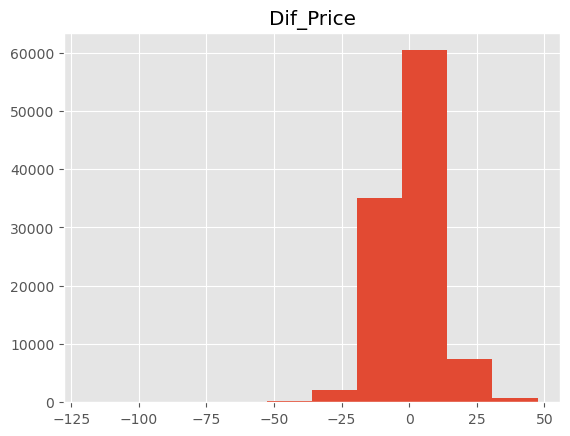

In [154]:
resultados.hist("Dif_Price");

**Métricas**

In [155]:
# Utilizamos la métrica del error absoluto medio
print ("MAE", metrics.mean_absolute_error(y_test, y_predict))

MAE 7.281266857789795


Guardamos la predicción

In [156]:
renfe_test_predict = pd.concat([X_test, resultados], axis = 1)
renfe_test_predict.head(10).T

,303428,36293,266099,159641,136381,259880,78276,53567,97679,26528
TIEMPO_VIAJE,0.37,0.34,0.00,0.09,0.20,0.03,0.60,0.17,0.20,0.11
DIF_INIT_BUS,0.14,0.66,0.02,0.53,0.13,0.96,0.23,0.76,0.39,0.44
FECHA_INICIO_HORA,0.45,0.20,0.25,0.70,0.25,0.95,1.00,0.50,0.85,0.30
FECHA_INICIO_DIA,0.80,0.77,0.10,0.90,0.97,0.50,0.17,0.87,0.17,0.60
FECHA_INICIO_MES,0.00,0.17,0.33,0.33,0.33,0.67,0.33,0.33,0.17,0.33
FECHA_FIN_HORA,0.70,0.43,0.39,0.83,0.43,1.00,0.17,0.65,0.96,0.43
CIUDAD_ORIGEN_BARCELONA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
CIUDAD_ORIGEN_MADRID,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00
CIUDAD_ORIGEN_PONFERRADA,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CIUDAD_ORIGEN_SEVILLA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [157]:
os.mkdir('predict')
renfe_test_predict.to_csv('predict/renfe_test_predict.csv')
renfe_test_predict.to_pickle('predict/renfe_test_predict.pkl')